# Smart Parking Experiment (using beacon, ML)

## Import list

In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import os

## Method definition

In [2]:
def read_test_data(set_num, model_name):
    if model_name == 5:
        raw_data = np.loadtxt("C:\\Users\\lcs53\\PycharmProjects\\test\\database\\training\\car_in\\a_train_" +str(set_num)+ '.csv', delimiter=',', dtype=np.float32)
    if model_name == 6:
        raw_data = np.loadtxt("C:\\Users\\lcs53\\PycharmProjects\\test\\database\\training\\car_out\\b_train_" +str(set_num)+ '.csv', delimiter=',', dtype=np.float32)
        
    b_data    = raw_data[:,0:3]
    cell_data = raw_data[:,3:10]

    return b_data, cell_data

def read_denoised_test_data(set_num, model_name):
    if model_name == 5:
        raw_data = np.loadtxt("C:\\Users\\lcs53\\PycharmProjects\\test\\database\\training\\car_in\\normalize\\a_train_" +str(set_num)+ '_normalize.csv', delimiter=',', dtype=np.float32)
    if model_name == 6:
        raw_data = np.loadtxt("C:\\Users\\lcs53\\PycharmProjects\\test\\database\\training\\car_out\\normalize\\b_train_" +str(set_num)+ '_normalize.csv', delimiter=',', dtype=np.float32)
        
    b_data    = raw_data[:,0:3]
    cell_data = raw_data[:,3:10]

    return b_data, cell_data

def convert_into_list(data, end_line):
    list_data = []

    for line in range(end_line*7):
        for index in range(0, 7):
            if data[line][index] == 1:
                list_data.append(index + 1)
    return list_data

# [Part 1] Car Out Experiment Analysis

###  Flow : raw data → AutoEncoder → denoised data → DNN → output

In [3]:
#model_name: 5(car_in) / 6(car_out)
model_name = 6
train_set_num = 2000
test_set_num = 1000

x_train_noisy,  y_train_noisy  = read_test_data(train_set_num, model_name)
# x_train_normal, y_train_normal = read_normalized_test_data(train_set_num, model_name)
x_test_noisy,   y_test_noisy   = read_test_data(test_set_num, model_name)
# x_test_normal,  y_test_normal  = read_normalized_test_data(test_set_num, model_name)

### (1) Denoising data generation
* Training data(denoised)
* Testing data(denoised)

In [17]:
import random
import matplotlib.pyplot as plt
import mglearn
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [18]:
BASE_PATH = "C:\\Users\\lcs53\\PycharmProjects\\test\\database\\training\\car_out\\"
def denoised_value(data):
    return data.mean() + random.choice([1, -1]) * (random.random() * np.std(data)/2)

def make_plot(y, num, begin, end):  
    x = range(len(y))
    plt.figure(figsize=(15, 5))
    plt.bar(x, y, color="blue")
    plt.axis([0,num, begin, end])
    plt.show()
    
    
def frequent_value(numbers):
    c = Counter(numbers) 
    mode = c.most_common(1) 
    return mode[0][0]

def convert_array_into_list(data):
    for num in range(1,8):
        data[num] = data[num].tolist()
        
    return data
    
def repeat_processed(data, AVG, STD):
#     print(data.shape)
    while (data.max() - AVG) > STD:
#         print(data.max())
        data = np.where(data==data.max(), denoised_value(data), data)

    while -(data.min() - AVG) > STD:
#         print(data.min())
        data = np.where(data==data.min(), denoised_value(data), data)
    
    return data


def data_denoised(data, set_num, plot_size, beacon_num):
    print("beacon_num: " + str(beacon_num+1))
    
    # first step
    STD = np.std(data[0:set_num])
    AVG = data[0:set_num].mean()
    print("Step:1, STD: %f, AVG: %f"%(STD, AVG))
    processed_data = repeat_processed(data[0:set_num], AVG, STD)
    
    # second step
    for i in range(1,7):
        begin = i*set_num
        end   = (i+1)*set_num
        AVG   = data[begin:end].mean()
        STD   = np.std(data[begin:end])
        print("Step:%d, STD: %f, AVG: %f"%(i+1, STD, AVG))
        row_value = repeat_processed(data[begin:end], AVG, STD)
        processed_data = np.vstack([processed_data, row_value])

    return processed_data

def save_file(x, y, set_num):
    print("Success Saved")
    f = open(BASE_PATH + "normalize\\b_train_"+ str(set_num) + "_normalize.csv", "a")
    for i in range(0,set_num*7):
        output = "%d,%d,%d,%d,%d,%d,%d,%d,%d,%d\n" % (x[i,0],x[i,1],x[i,2],y[i][0],y[i][1],y[i][2],y[i][3],y[i][4],y[i][5],y[i][6])
        f.write(output)
    f.close()

#### 1) Training data(denoised)

In [19]:
#model_name: 5(car_in) / 6(car_out)
model_name = 6
set_num = 2000
b_data, cell_data = read_test_data(set_num, model_name)

x_data = b_data[:, 0:set_num*7]
y_data = cell_data

In [20]:
x_data.shape

(14000, 3)

In [21]:
y_data.shape

(14000, 7)

In [22]:
x_data[:,0].shape

(14000,)

In [23]:
plot_size = set_num*7
# AVG = data[0:set_num].mean()
x_denoised_data_1 = data_denoised(x_data[:,0].reshape(plot_size,1), set_num, plot_size, 0)
x_denoised_data_2 = data_denoised(x_data[:,1].reshape(plot_size,1), set_num, plot_size, 1)
x_denoised_data_3 = data_denoised(x_data[:,2].reshape(plot_size,1), set_num, plot_size, 2)

beacon_num: 1
Step:1, STD: 1.461357, AVG: -65.793999
Step:2, STD: 1.626849, AVG: -66.821503
Step:3, STD: 2.515899, AVG: -82.250504
Step:4, STD: 0.917625, AVG: -78.157997
Step:5, STD: 2.510367, AVG: -85.416000
Step:6, STD: 1.394014, AVG: -72.082001
Step:7, STD: 1.884474, AVG: -74.765999
beacon_num: 2
Step:1, STD: 1.487724, AVG: -86.526001
Step:2, STD: 0.878544, AVG: -79.060501
Step:3, STD: 2.076771, AVG: -70.358498
Step:4, STD: 4.648653, AVG: -85.968002
Step:5, STD: 1.591332, AVG: -81.046501
Step:6, STD: 1.542722, AVG: -78.714500
Step:7, STD: 4.503563, AVG: -88.088997
beacon_num: 3
Step:1, STD: 1.992734, AVG: -80.752998
Step:2, STD: 4.189958, AVG: -83.250504
Step:3, STD: 2.436891, AVG: -80.460503
Step:4, STD: 1.157531, AVG: -84.466499
Step:5, STD: 1.244260, AVG: -85.896004
Step:6, STD: 1.562821, AVG: -76.009499
Step:7, STD: 1.977164, AVG: -69.758499


In [24]:
begin = -60
end = -95
print("Raw data: 1's beacon")
# make_plot(x_data[:,0], plot_size, begin, end)
print("Denoised data: 1's beacon")
# make_plot(x_denoised_data_1.T[0], plot_size, begin, end)

Raw data: 1's beacon
Denoised data: 1's beacon


In [25]:
begin = -60
end = -100
print("Raw data: 2's beacon")
# make_plot(x_data[:,1], plot_size, begin, end)
print("Denoised data: 2's beacon")
# make_plot(x_denoised_data_2.T[0], plot_size, begin, end)

Raw data: 2's beacon
Denoised data: 2's beacon


In [26]:
begin = -60
end = -100
print("Raw data: 3's beacon")
# make_plot(x_data[:,2], plot_size, begin, end)
print("Denoised data: 3's beacon")
# make_plot(x_denoised_data_3.T[0], plot_size, begin, end)

Raw data: 3's beacon
Denoised data: 3's beacon


In [130]:
x_denoised_data_1.shape

(14000, 1)

In [131]:
x_denoised_data = np.hstack([x_denoised_data_1, x_denoised_data_2])
x_denoised_data = np.hstack([x_denoised_data, x_denoised_data_3])

In [132]:
x_denoised_data.shape

(14000, 3)

In [133]:
y_data.shape

(14000, 7)

In [134]:
set_num

2000

In [136]:
save_file(x_denoised_data, y_data, set_num)

Success Saved


#### 2) Testing data(denoised)

In [138]:
#model_name: 5(car_in) / 6(car_out)
model_name = 6
set_num = 1000
b_data, cell_data = read_test_data(set_num, model_name)

x_data = b_data[:, 0:set_num*7]
y_data = cell_data

In [139]:
x_data.shape

(7000, 3)

In [140]:
y_data.shape

(7000, 7)

In [141]:
x_data[:,0].shape

(7000,)

In [142]:
plot_size = set_num*7
# AVG = data[0:set_num].mean()
x_denoised_data_1 = data_denoised(x_data[:,0].reshape(plot_size,1), set_num, plot_size, 0)
x_denoised_data_2 = data_denoised(x_data[:,1].reshape(plot_size,1), set_num, plot_size, 1)
x_denoised_data_3 = data_denoised(x_data[:,2].reshape(plot_size,1), set_num, plot_size, 2)

beacon_num: 1
Step:1, STD: 1.499541, AVG: -65.875999
Step:2, STD: 1.683508, AVG: -66.848999
Step:3, STD: 2.512516, AVG: -82.208000
Step:4, STD: 0.871319, AVG: -78.202003
Step:5, STD: 2.421817, AVG: -85.348999
Step:6, STD: 1.384029, AVG: -72.092003
Step:7, STD: 1.900631, AVG: -74.760002
beacon_num: 2
Step:1, STD: 1.472435, AVG: -86.543999
Step:2, STD: 0.868396, AVG: -79.083000
Step:3, STD: 2.080614, AVG: -70.362000
Step:4, STD: 4.750403, AVG: -86.108002
Step:5, STD: 1.544013, AVG: -81.055000
Step:6, STD: 1.540909, AVG: -78.660004
Step:7, STD: 4.491289, AVG: -88.139000
beacon_num: 3
Step:1, STD: 1.998119, AVG: -80.789001
Step:2, STD: 4.116921, AVG: -83.219002
Step:3, STD: 2.411738, AVG: -80.460999
Step:4, STD: 1.159120, AVG: -84.478996
Step:5, STD: 1.148967, AVG: -85.874001
Step:6, STD: 1.527732, AVG: -75.994003
Step:7, STD: 1.998099, AVG: -69.760002


In [143]:
begin = -60
end = -95
print("Raw data: 1's beacon")
# make_plot(x_data[:,0], plot_size, begin, end)
print("Denoised data: 1's beacon")
# make_plot(x_denoised_data_1.T[0], plot_size, begin, end)

Raw data: 1's beacon
Denoised data: 1's beacon


In [144]:
begin = -60
end = -100
print("Raw data: 2's beacon")
# make_plot(x_data[:,1], plot_size, begin, end)
print("Denoised data: 2's beacon")
# make_plot(x_denoised_data_2.T[0], plot_size, begin, end)

Raw data: 2's beacon
Denoised data: 2's beacon


In [145]:
begin = -60
end = -100
print("Raw data: 3's beacon")
# make_plot(x_data[:,2], plot_size, begin, end)
print("Denoised data: 3's beacon")
# make_plot(x_denoised_data_3.T[0], plot_size, begin, end)

Raw data: 3's beacon
Denoised data: 3's beacon


In [146]:
x_denoised_data_1.shape

(7000, 1)

In [147]:
x_denoised_data = np.hstack([x_denoised_data_1, x_denoised_data_2])
x_denoised_data = np.hstack([x_denoised_data, x_denoised_data_3])

In [148]:
x_denoised_data.shape

(7000, 3)

In [149]:
y_data.shape

(7000, 7)

In [150]:
set_num

1000

In [154]:
save_file(x_denoised_data, y_data, set_num)

Success Saved


### (2) Raw data & Denoised data
* Training data(raw)
* Testing data(raw)

* Training data(denoised)
* Testing data(denoised)

In [4]:
#model_name: 5(car_in) / 6(car_out)
model_name = 6
train_set_num = 2000
test_set_num = 1000

x_train_noisy,  y_train_noisy      = read_test_data(train_set_num, model_name)
x_train_denoised, y_train_denoised = read_denoised_test_data(train_set_num, model_name)
x_test_noisy,   y_test_noisy       = read_test_data(test_set_num, model_name)
x_test_denoised,  y_test_denoised  = read_denoised_test_data(test_set_num, model_name)

In [5]:
ae_x_train_noisy = x_train_noisy.astype('float32')/ -100.
ae_x_train_denoised = x_train_denoised.astype('float32')/ -100.
ae_x_test_noisy = x_test_noisy.astype('float32')/ -100.
ae_x_test_denoised = x_test_denoised.astype('float32')/ -100.

In [6]:
ae_x_test_noisy.shape

(7000, 3)

In [7]:
x_train_noisy.shape

(14000, 3)

In [8]:
x_train_denoised.shape

(14000, 3)

In [9]:
x_test_noisy.shape

(7000, 3)

In [10]:
x_test_denoised.shape

(7000, 3)

### (3) Denoising AutoEncoder
* Model layer shape = 3 -> 128->64->32->64->128->3
* Process
    * Training data(raw) → AutoEncoder → Training data(denoised)
    * Testing  data(raw)  → AutoEncoder → Testing  data(denoised)


In [11]:
from keras.layers import Input, Dense
from keras.models import Model

#input layer
input_rssi = Input(shape=(3,))

#3-layer encoder
encoded = Dense(128, activation='relu')(input_rssi)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

#3-layer decoder
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(3, activation='sigmoid')(decoded)

#create auto_encoder
autoencoder = Model(input_rssi, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(ae_x_train_noisy, ae_x_train_denoised,
                epochs=1000,
                batch_size=256,
                shuffle=True,
                validation_data=(ae_x_test_noisy, ae_x_test_denoised),)

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Use tf.cast instead.
Train on 14000 samples, validate on 7000 samples
Epoch 1/1000
14000/14000 [==============================] - 2s 120us/step - loss: 0.5371 - val_loss: 0.5178
Epoch 2/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5167 - val_loss: 0.5177
Epoch 3/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5166 - val_loss: 0.5176
Epoch 4/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5165 - val_loss: 0.5173
Epoch 5/1000
14000/14000 [==============================] - 0s 17us/step - loss: 0.5161 - val_loss: 0.5172
Epoch 6/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5163 - val_loss: 0.5175
Epoch 7/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5161 - val_loss: 0.5161
Epoch 8/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5149 - val_loss: 0.5170
Epoch 9/1000
14000/14000 [====================

Epoch 74/1000
14000/14000 [==============================] - 0s 21us/step - loss: 0.5081 - val_loss: 0.5090
Epoch 75/1000
14000/14000 [==============================] - 0s 21us/step - loss: 0.5083 - val_loss: 0.5090
Epoch 76/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5080 - val_loss: 0.5088
Epoch 77/1000
14000/14000 [==============================] - 0s 20us/step - loss: 0.5080 - val_loss: 0.5092
Epoch 78/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5082 - val_loss: 0.5087
Epoch 79/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5080 - val_loss: 0.5091
Epoch 80/1000
14000/14000 [==============================] - 0s 20us/step - loss: 0.5081 - val_loss: 0.5094
Epoch 81/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5080 - val_loss: 0.5086
Epoch 82/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5081 - val_loss: 0.5089
Epoch 83/1000
14000/14000 [=

14000/14000 [==============================] - 0s 18us/step - loss: 0.5075 - val_loss: 0.5085
Epoch 225/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5076 - val_loss: 0.5083
Epoch 226/1000
14000/14000 [==============================] - 0s 17us/step - loss: 0.5075 - val_loss: 0.5083
Epoch 227/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5075 - val_loss: 0.5083
Epoch 228/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5075 - val_loss: 0.5084
Epoch 229/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5075 - val_loss: 0.5083
Epoch 230/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5075 - val_loss: 0.5083
Epoch 231/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5074 - val_loss: 0.5084
Epoch 232/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5075 - val_loss: 0.5084
Epoch 233/1000
14000/14000 [======

14000/14000 [==============================] - 0s 18us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 375/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5074 - val_loss: 0.5082
Epoch 376/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5074 - val_loss: 0.5082
Epoch 377/1000
14000/14000 [==============================] - 0s 17us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 378/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5074 - val_loss: 0.5082
Epoch 379/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5074 - val_loss: 0.5082
Epoch 380/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5074 - val_loss: 0.5082
Epoch 381/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5074 - val_loss: 0.5082
Epoch 382/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 383/1000
14000/14000 [======

14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 450/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 451/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 452/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 453/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 454/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 455/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 456/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 457/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 458/1000
14000/14000 [======

14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 600/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 601/1000
14000/14000 [==============================] - 0s 20us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 602/1000
14000/14000 [==============================] - 0s 20us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 603/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 604/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 605/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 606/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 607/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 608/1000
14000/14000 [======

14000/14000 [==============================] - 0s 21us/step - loss: 0.5073 - val_loss: 0.5081
Epoch 750/1000
14000/14000 [==============================] - 0s 22us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 751/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5081
Epoch 752/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 753/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 754/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 755/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 756/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5081
Epoch 757/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5081
Epoch 758/1000
14000/14000 [======

14000/14000 [==============================] - 0s 20us/step - loss: 0.5073 - val_loss: 0.5081
Epoch 900/1000
14000/14000 [==============================] - 0s 21us/step - loss: 0.5073 - val_loss: 0.5081
Epoch 901/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5081
Epoch 902/1000
14000/14000 [==============================] - 0s 18us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 903/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 904/1000
14000/14000 [==============================] - 0s 22us/step - loss: 0.5073 - val_loss: 0.5081
Epoch 905/1000
14000/14000 [==============================] - 0s 24us/step - loss: 0.5073 - val_loss: 0.5082
Epoch 906/1000
14000/14000 [==============================] - 0s 23us/step - loss: 0.5073 - val_loss: 0.5081
Epoch 907/1000
14000/14000 [==============================] - 0s 19us/step - loss: 0.5073 - val_loss: 0.5081
Epoch 908/1000
14000/14000 [======

In [163]:
begin = -60
end = -100

#### 1) AutoEncoder Before & After(Train data)
* Raw data
* Denoised data
* After AutoEncoder

In [12]:
#model_name: 5(car_in) / 6(car_out)
model_name = 6
train_set_num = 2000
test_set_num = 1000

x_train_noisy,  y_train_noisy  = read_test_data(train_set_num, model_name)
x_test_noisy,   y_test_noisy   = read_test_data(test_set_num, model_name)

ae_x_train_noisy = x_train_noisy.astype('float32')/ -100.
ae_x_test_noisy = x_test_noisy.astype('float32')/ -100.

In [13]:
y = x_train_noisy[:,[0]].T[0]
# make_plot(y, train_set_num * 7, begin, end)

y = x_train_denoised[:,[0]].T[0]
# make_plot(y, train_set_num * 7, begin, end)

after_autoencoder_x_train = autoencoder.predict(ae_x_train_noisy)* (-100)
# make_plot(after_autoencoder_x_train[:, [0]].T[0], train_set_num * 7, begin, end)

#### 2) AutoEncoder Before & After(Test data)
* Raw data
* Denoised data
* After AutoEncoder

In [14]:
y = x_test_noisy[:,[0]].T[0]
# make_plot(y, test_set_num * 7, begin, end)

# y = x_test_denoised[:,[0]].T[0]
# make_plot(y, test_set_num * 7, begin, end)

after_autoencoder_x_test = autoencoder.predict(ae_x_test_noisy)* (-100)
# make_plot(after_autoencoder_x_test[:, [0]].T[0], test_set_num * 7, begin, end)

In [15]:
after_autoencoder_x_train.shape

(14000, 3)

In [16]:
after_autoencoder_x_test.shape

(7000, 3)

### (4) Make Noised Data
* Before_AE_New_Test_data stdev : 1.61
* After_AE_New_Test_data stdev  : 0.54

In [1]:
x_train_noisy, cell_data = read_test_data(train_set_num, model_name)
target  = convert_into_list(cell_data, train_set_num)

y_train = np.array(target)

NameError: name 'read_test_data' is not defined

In [ ]:
x_test_noisy, cell_data = read_test_data(test_set_num, model_name)
target  = convert_into_list(cell_data, test_set_num)

y_test= np.array(target)

In [19]:
y_train

array([1, 1, 1, ..., 7, 7, 7])

In [20]:
x_train_noisy.shape

(14000, 3)

In [21]:
x_test_noisy.shape

(7000, 3)

In [22]:
x_train_noisy[0:2000,0].shape

(2000,)

In [23]:
print("Train_data average:"+str(x_train_noisy[0:train_set_num,0].mean()))
print("Train_data stdev:"+str(np.std(x_train_noisy[0:train_set_num,0])))

print("Test_data average:"+str(x_test_noisy[0:test_set_num,0].mean()))
print("Test_data stdev:"+str(np.std(x_test_noisy[0:test_set_num,0])))

Train_data average:-65.794
Train_data stdev:1.4613569
Test_data average:-65.876
Test_data stdev:1.4995414


In [24]:
print("After_AE_Train_data average:"+str(after_autoencoder_x_train[0:train_set_num,0].mean()))
print("After_AE_Train_data stdev:"+str(np.std(after_autoencoder_x_train[0:train_set_num,0]))+"\n")

print("After_AE_Test_data average:"+str(after_autoencoder_x_test[0:test_set_num,0].mean()))
print("After_AE_Test_data stdev:"+str(np.std(after_autoencoder_x_test[0:test_set_num,0]))+"\n")

After_AE_Train_data average:-65.50794
After_AE_Train_data stdev:0.4399696

After_AE_Test_data average:-65.53103
After_AE_Test_data stdev:0.4413523



In [27]:
import random

noise_factor = 0.6
new_x_test_noisy = x_test_noisy + noise_factor * np.random.normal(loc=1.5, scale=1.0, size=x_test_noisy.shape)

print("Raw Test data")
# make_plot(x_test_noisy[:, [0]].T[0], test_set_num * 7, begin, end)

print("Make Noised Test data")
# make_plot(new_x_test_noisy[:, [0]].T[0], test_set_num * 7, begin, end)

print("After AutoEncoder Test data")
new_ae_x_test_noisy = new_x_test_noisy.astype('float32')/ -100.
new_after_autoencoder_x_test = autoencoder.predict(new_ae_x_test_noisy)* (-100)
# make_plot(new_after_autoencoder_x_test[:, [0]].T[0], test_set_num * 7, begin, end)

Raw Test data
Make Noised Test data
After AutoEncoder Test data


In [28]:
print("Test_data average:"+str(x_test_noisy[0:test_set_num,0].mean()))
print("Test_data stdev:"+str(np.std(x_test_noisy[0:test_set_num,0]))+"\n")

print("New_Test_data average:"+str(new_x_test_noisy[0:test_set_num,0].mean()))
print("New_Test_data stdev:"+str(np.std(new_x_test_noisy[0:test_set_num,0]))+"\n")

print("After_AE_New_Test_data average:"+str(new_after_autoencoder_x_test[0:test_set_num,0].mean()))
print("After_AE_New_Test_data stdev:"+str(np.std(new_after_autoencoder_x_test[0:test_set_num,0])))

Test_data average:-65.876
Test_data stdev:1.4995414

New_Test_data average:-64.97578613888184
New_Test_data stdev:1.6257219321143916

After_AE_New_Test_data average:-65.486946
After_AE_New_Test_data stdev:0.41730422


### (5) SVM model
* Training data(raw) → AutoEncoder → Training data(denoised)  → SVM  → Output
* Testing  data(raw)  → AutoEncoder → Testing  data(denoised)  → SVM  → Output

In [179]:
x_train_noisy, cell_data = read_test_data(train_set_num, model_name)
target  = convert_into_list(cell_data, train_set_num)

y_train = np.array(target)

In [180]:
x_test_noisy, cell_data = read_test_data(test_set_num, model_name)
target  = convert_into_list(cell_data, test_set_num)

y_test= np.array(target)

In [181]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

scaler = MinMaxScaler()
scaler.fit(x_train_noisy)
before_autoencoder_x_train_scaled = scaler.fit_transform(x_train_noisy)
before_autoencoder_x_test_scaled = scaler.transform(x_test_noisy)

scaler = MinMaxScaler()
scaler.fit(after_autoencoder_x_train)
after_autoencoder_x_train_scaled = scaler.fit_transform(after_autoencoder_x_train)
after_autoencoder_x_test_scaled = scaler.transform(after_autoencoder_x_test)

In [182]:
before_autoencoder_x_train_scaled.shape

(14000, 3)

In [183]:
after_autoencoder_x_train_scaled.shape

(14000, 3)

In [184]:
y_train.shape

(14000,)

In [185]:
y_test.shape

(7000,)

In [186]:
after_autoencoder_x_test_scaled.shape

(7000, 3)

In [187]:
before_autoencoder_svc = SVC(C=1000, gamma=100, decision_function_shape='ovo')
before_autoencoder_svc.fit(before_autoencoder_x_train_scaled, y_train)

after_autoencoder_svc = SVC(C=1000, gamma=100, decision_function_shape='ovo')
after_autoencoder_svc.fit(after_autoencoder_x_train_scaled, y_train)

print("Before AutoEncoder Train accuracy: {:.3f}".format(before_autoencoder_svc.score(before_autoencoder_x_train_scaled, y_train)))
print("Before AutoEncoder Test accuracy: {:.3f}".format(before_autoencoder_svc.score(before_autoencoder_x_test_scaled, y_test)))

print("After AutoEncoder Training accuracy: {:.3f}".format(after_autoencoder_svc.score(after_autoencoder_x_train_scaled, y_train)))
print("After AutoEncoder Test accuracy: {:.3f}".format(after_autoencoder_svc.score(after_autoencoder_x_test_scaled, y_test)))

Before AutoEncoder Train accuracy: 0.999
Before AutoEncoder Test accuracy: 0.999
After AutoEncoder Training accuracy: 0.999
After AutoEncoder Test accuracy: 0.999


#### 1) Noised Data Analysis (SVM model)
* Before AutoEncoder New Test accuracy: 0.967
* After AutoEncoder Test accuracy: 0.981

Results increased 1.4%

In [29]:
new_x_test_noisy.shape

(7000, 3)

In [30]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

scaler = MinMaxScaler()
# scaler.fit(x_train_noisy) #average, stdev
before_autoencoder_x_train_scaled = scaler.fit_transform(x_train_noisy)
before_autoencoder_x_test_scaled = scaler.transform(new_x_test_noisy)

scaler = MinMaxScaler()
# scaler.fit(after_autoencoder_x_train)
after_autoencoder_x_train_scaled = scaler.fit_transform(after_autoencoder_x_train)
after_autoencoder_x_test_scaled = scaler.transform(new_after_autoencoder_x_test)

In [31]:
new_after_autoencoder_x_test.shape

(7000, 3)

In [32]:
before_autoencoder_svc = SVC(C=1000, gamma=1000, decision_function_shape='ovo')
before_autoencoder_svc.fit(before_autoencoder_x_train_scaled, y_train)

after_autoencoder_svc = SVC(C=1000, gamma=1000, decision_function_shape='ovo')
after_autoencoder_svc.fit(after_autoencoder_x_train_scaled, y_train)

print("Before AutoEncoder New Test accuracy: {:.3f}".format(before_autoencoder_svc.score(before_autoencoder_x_test_scaled, y_test)))
print("After AutoEncoder Test accuracy: {:.3f}".format(after_autoencoder_svc.score(after_autoencoder_x_test_scaled, y_test)))

Before AutoEncoder New Test accuracy: 0.968
After AutoEncoder Test accuracy: 0.982


In [33]:
after_autoencoder_svc.score(after_autoencoder_x_test_scaled, y_test)

0.9822857142857143

##### Prediction

In [192]:
new_after_autoencoder_x_test.shape

(7000, 3)

In [193]:
ae_cell_1 = new_after_autoencoder_x_test[test_set_num*0:test_set_num*1] #parking slot 1
ae_cell_2 = new_after_autoencoder_x_test[test_set_num*1:test_set_num*2] #parking slot 2
ae_cell_3 = new_after_autoencoder_x_test[test_set_num*2:test_set_num*3] #parking slot 3
ae_cell_4 = new_after_autoencoder_x_test[test_set_num*3:test_set_num*4] #parking slot 4
ae_cell_5 = new_after_autoencoder_x_test[test_set_num*4:test_set_num*5] #parking slot 5
ae_cell_6 = new_after_autoencoder_x_test[test_set_num*5:test_set_num*6] #parking slot 6
ae_cell_7 = new_after_autoencoder_x_test[test_set_num*6:test_set_num*7] #parking slot 7

In [194]:
ae_cell_1.shape

(1000, 3)

In [195]:
scaler = MinMaxScaler()
scaler.fit(after_autoencoder_x_train)
after_autoencoder_x_test_scaled = scaler.transform(new_after_autoencoder_x_test)

after_autoencoder_svc = SVC(C=1000, gamma=1000, decision_function_shape='ovo')
after_autoencoder_svc.fit(after_autoencoder_x_train_scaled, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=1000, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [196]:
ae_x_test_scaled_1 = scaler.transform(ae_cell_1)
ae_x_test_scaled_2 = scaler.transform(ae_cell_2)
ae_x_test_scaled_3 = scaler.transform(ae_cell_3)
ae_x_test_scaled_4 = scaler.transform(ae_cell_4)
ae_x_test_scaled_5 = scaler.transform(ae_cell_5)
ae_x_test_scaled_6 = scaler.transform(ae_cell_6)
ae_x_test_scaled_7 = scaler.transform(ae_cell_7)

In [197]:
ae_x_test_scaled_1.shape

(1000, 3)

* Counter function

In [198]:
from collections import Counter
myList =  [1, 2, 3, 4, 1, 4, 1]

print ("---Counter()---")
result = Counter(myList)
print(result)
tmp = []

for key in result:
    tmp.append(result[key])
    print(str(key)+" : "+ str(result[key]))

print(tmp)

#키 없이 카운트 한 값만 알아내고 싶으면
print ("---Counter().values()---")
result = Counter(myList).values()
print(result)

---Counter()---
Counter({1: 3, 4: 2, 2: 1, 3: 1})
1 : 3
2 : 1
3 : 1
4 : 2
[3, 1, 1, 2]
---Counter().values()---
dict_values([3, 1, 1, 2])


In [199]:
from collections import Counter

def value_counter(myList, cell_num):
    result = Counter(myList)
    print("Cell " + str(cell_num) + " :"+ str(result))
    count_list = []

    for key in result:
        count_list.append(result[key])
        print(str(key)+" : "+ str(result[key]))
    print("\n")
    return count_list

In [200]:
ae_prediction_1 = after_autoencoder_svc.predict(ae_x_test_scaled_1)
ae_prediction_2 = after_autoencoder_svc.predict(ae_x_test_scaled_2)
ae_prediction_3 = after_autoencoder_svc.predict(ae_x_test_scaled_3)
ae_prediction_4 = after_autoencoder_svc.predict(ae_x_test_scaled_4)
ae_prediction_5 = after_autoencoder_svc.predict(ae_x_test_scaled_5)
ae_prediction_6 = after_autoencoder_svc.predict(ae_x_test_scaled_6)
ae_prediction_7 = after_autoencoder_svc.predict(ae_x_test_scaled_7)

value_counter(ae_prediction_1,1)
value_counter(ae_prediction_2,2)
value_counter(ae_prediction_3,3)
value_counter(ae_prediction_4,4)
value_counter(ae_prediction_5,5)
value_counter(ae_prediction_6,6)
value_counter(ae_prediction_7,7)

Cell 1 :Counter({1: 993, 4: 4, 2: 3})
4 : 4
1 : 993
2 : 3


Cell 2 :Counter({2: 986, 6: 6, 4: 5, 1: 3})
2 : 986
4 : 5
6 : 6
1 : 3


Cell 3 :Counter({3: 996, 4: 4})
3 : 996
4 : 4


Cell 4 :Counter({4: 995, 5: 5})
4 : 995
5 : 5


Cell 5 :Counter({5: 965, 4: 35})
4 : 35
5 : 965


Cell 6 :Counter({6: 970, 2: 22, 4: 8})
6 : 970
4 : 8
2 : 22


Cell 7 :Counter({7: 990, 4: 10})
7 : 990
4 : 10




[990, 10]

#### Confusion Matrix

In [201]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

before_prediction = before_autoencoder_svc.predict(before_autoencoder_x_test_scaled)
before_cm = confusion_matrix(y_test, before_prediction)

after_prediction = after_autoencoder_svc.predict(after_autoencoder_x_test_scaled)
after_cm = confusion_matrix(y_test, after_prediction)

* Before AutoEncoder Confusion Matrix

In [202]:
print(before_cm)

[[966   2   0  32   0   0   0]
 [  0 958   0  33   0   9   0]
 [  0   0 988  12   0   0   0]
 [  0   0   0 996   4   0   0]
 [  0   0   1  30 969   0   0]
 [  0  28   0  31   0 941   0]
 [  0   0   0  38   0   0 962]]


* After AutoEncoder Confusion Matrix

In [203]:
print(after_cm)

[[993   3   0   4   0   0   0]
 [  3 986   0   5   0   6   0]
 [  0   0 996   4   0   0   0]
 [  0   0   0 995   5   0   0]
 [  0   0   0  35 965   0   0]
 [  0  22   0   8   0 970   0]
 [  0   0   0  10   0   0 990]]


In [204]:
ae_prediction_1.shape

(1000,)

### (6) MLP model
* Before AutoEncoder New Test accuracy: 0.967
* After AutoEncoder Test accuracy: 0.981

Results increased 1.4%

#### 1) Before AutoEncoder
* Before AutoEncoder Training accuracy : 1.00
* Before AutoEncoder Testing  accuracy : 0.98

In [205]:
new_x_test_noisy.shape

(7000, 3)

In [206]:
y_test.shape

(7000,)

In [207]:
# before_autoencoder_x_test_scaled, y_test
# after_autoencoder_x_test_scaled, y_test

In [208]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# before_ae_x_train_scaled = scaler.fit_transform(x_train_noisy)
# before_ae_x_test_scaled = scaler.transform(new_x_test_noisy)
before_mlp = MLPClassifier(random_state=12, hidden_layer_sizes=[50, 100, 50], max_iter=1000, alpha=0.001,solver='sgd', verbose=10,tol=0.000000001).fit(before_autoencoder_x_train_scaled, y_train_noisy)
# before_mlp = MLPClassifier(random_state=12, hidden_layer_sizes=[50, 100, 50], max_iter=1000, alpha=0.001,solver='sgd', verbose=10,tol=0.000000001).fit(before_ae_x_train_scaled, y_train_noisy)
print("Before AutoEncoder Training accuracy : {:.2f}".format(before_mlp.score(before_autoencoder_x_train_scaled, y_train_noisy)))
print("Before AutoEncoder Testing  accuracy : {:.2f}".format(before_mlp.score(before_autoencoder_x_test_scaled, y_test_noisy)))

Iteration 1, loss = 3.56245317
Iteration 2, loss = 2.87192026
Iteration 3, loss = 2.84322621
Iteration 4, loss = 2.82812338
Iteration 5, loss = 2.81160330
Iteration 6, loss = 2.79188030
Iteration 7, loss = 2.76584502
Iteration 8, loss = 2.73299413
Iteration 9, loss = 2.69270255
Iteration 10, loss = 2.64209539
Iteration 11, loss = 2.57838489
Iteration 12, loss = 2.50127728
Iteration 13, loss = 2.41263536
Iteration 14, loss = 2.31670683
Iteration 15, loss = 2.21858797
Iteration 16, loss = 2.12146305
Iteration 17, loss = 2.02548905
Iteration 18, loss = 1.93643017
Iteration 19, loss = 1.85478226
Iteration 20, loss = 1.77962646
Iteration 21, loss = 1.71238524
Iteration 22, loss = 1.65253345
Iteration 23, loss = 1.59912303
Iteration 24, loss = 1.54963721
Iteration 25, loss = 1.50190671
Iteration 26, loss = 1.45510920
Iteration 27, loss = 1.40797482
Iteration 28, loss = 1.35906250
Iteration 29, loss = 1.30781834
Iteration 30, loss = 1.25214214
Iteration 31, loss = 1.19322700
Iteration 32, los

Iteration 253, loss = 0.03455222
Iteration 254, loss = 0.03461228
Iteration 255, loss = 0.03444312
Iteration 256, loss = 0.03423001
Iteration 257, loss = 0.03438168
Iteration 258, loss = 0.03416829
Iteration 259, loss = 0.03418897
Iteration 260, loss = 0.03417865
Iteration 261, loss = 0.03404456
Iteration 262, loss = 0.03397869
Iteration 263, loss = 0.03388775
Iteration 264, loss = 0.03389482
Iteration 265, loss = 0.03385691
Iteration 266, loss = 0.03376125
Iteration 267, loss = 0.03376664
Iteration 268, loss = 0.03362973
Iteration 269, loss = 0.03375247
Iteration 270, loss = 0.03361202
Iteration 271, loss = 0.03362209
Iteration 272, loss = 0.03343400
Iteration 273, loss = 0.03342117
Iteration 274, loss = 0.03350303
Iteration 275, loss = 0.03337259
Iteration 276, loss = 0.03334664
Iteration 277, loss = 0.03324777
Iteration 278, loss = 0.03325437
Iteration 279, loss = 0.03303726
Iteration 280, loss = 0.03304071
Iteration 281, loss = 0.03302370
Iteration 282, loss = 0.03297770
Iteration 

Iteration 504, loss = 0.02686635
Iteration 505, loss = 0.02685329
Iteration 506, loss = 0.02679945
Iteration 507, loss = 0.02674248
Iteration 508, loss = 0.02676069
Iteration 509, loss = 0.02662738
Iteration 510, loss = 0.02671594
Iteration 511, loss = 0.02664067
Iteration 512, loss = 0.02665621
Iteration 513, loss = 0.02667064
Iteration 514, loss = 0.02656216
Iteration 515, loss = 0.02654019
Iteration 516, loss = 0.02677561
Iteration 517, loss = 0.02659737
Iteration 518, loss = 0.02666868
Iteration 519, loss = 0.02656400
Iteration 520, loss = 0.02652028
Iteration 521, loss = 0.02660477
Iteration 522, loss = 0.02641851
Iteration 523, loss = 0.02643265
Iteration 524, loss = 0.02660351
Iteration 525, loss = 0.02643792
Iteration 526, loss = 0.02642134
Iteration 527, loss = 0.02636190
Iteration 528, loss = 0.02648795
Iteration 529, loss = 0.02637162
Iteration 530, loss = 0.02639815
Iteration 531, loss = 0.02638293
Iteration 532, loss = 0.02632476
Iteration 533, loss = 0.02641801
Iteration 

In [209]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train_noisy)
# x_test_scaled = scaler.transform(x_test_noisy)

# after_ae_x_train_scaled = scaler.fit_transform(after_autoencoder_x_train)
# after_ae_x_test_scaled = scaler.transform(new_after_autoencoder_x_test)

after_mlp = MLPClassifier(random_state=12, hidden_layer_sizes=[50, 100, 50], max_iter=1000, alpha=0.001,solver='sgd', verbose=10,tol=0.000000001).fit(after_autoencoder_x_train_scaled, y_train_noisy)
print("After AutoEncoder Training accuracy : {:.2f}".format(after_mlp.score(after_autoencoder_x_train_scaled, y_train_noisy)))
print("After AutoEncoder Testing  accuracy : {:.2f}".format(after_mlp.score(after_autoencoder_x_test_scaled, y_test_noisy)))

Iteration 1, loss = 3.59686543
Iteration 2, loss = 2.85734872
Iteration 3, loss = 2.80574622
Iteration 4, loss = 2.76525466
Iteration 5, loss = 2.71505809
Iteration 6, loss = 2.65075336
Iteration 7, loss = 2.56728698
Iteration 8, loss = 2.46404239
Iteration 9, loss = 2.34229593
Iteration 10, loss = 2.21403163
Iteration 11, loss = 2.08449988
Iteration 12, loss = 1.95718329
Iteration 13, loss = 1.83008112
Iteration 14, loss = 1.70522257
Iteration 15, loss = 1.58673501
Iteration 16, loss = 1.47522906
Iteration 17, loss = 1.36651332
Iteration 18, loss = 1.26157135
Iteration 19, loss = 1.16007280
Iteration 20, loss = 1.05971399
Iteration 21, loss = 0.96123767
Iteration 22, loss = 0.86513689
Iteration 23, loss = 0.77312541
Iteration 24, loss = 0.68642068
Iteration 25, loss = 0.60903016
Iteration 26, loss = 0.54052648
Iteration 27, loss = 0.48093140
Iteration 28, loss = 0.42905884
Iteration 29, loss = 0.38433977
Iteration 30, loss = 0.34538180
Iteration 31, loss = 0.31200531
Iteration 32, los

Iteration 255, loss = 0.02542420
Iteration 256, loss = 0.02545163
Iteration 257, loss = 0.02539660
Iteration 258, loss = 0.02539053
Iteration 259, loss = 0.02535420
Iteration 260, loss = 0.02539732
Iteration 261, loss = 0.02543080
Iteration 262, loss = 0.02537345
Iteration 263, loss = 0.02529664
Iteration 264, loss = 0.02537771
Iteration 265, loss = 0.02526212
Iteration 266, loss = 0.02527136
Iteration 267, loss = 0.02530995
Iteration 268, loss = 0.02529510
Iteration 269, loss = 0.02535810
Iteration 270, loss = 0.02526827
Iteration 271, loss = 0.02525756
Iteration 272, loss = 0.02518905
Iteration 273, loss = 0.02529259
Iteration 274, loss = 0.02525902
Iteration 275, loss = 0.02518262
Iteration 276, loss = 0.02523143
Iteration 277, loss = 0.02510966
Iteration 278, loss = 0.02531721
Iteration 279, loss = 0.02515906
Iteration 280, loss = 0.02510844
Iteration 281, loss = 0.02518691
Iteration 282, loss = 0.02515063
Iteration 283, loss = 0.02508032
Iteration 284, loss = 0.02508243
Iteration 

In [113]:
print("After AutoEncoder Training accuracy : {:.2f}".format(after_mlp.score(after_autoencoder_x_train_scaled, y_train_noisy)))
print("After AutoEncoder Testing  accuracy : {:.2f}".format(after_mlp.score(after_autoencoder_x_test_scaled, y_test_noisy)))

After AutoEncoder Training accuracy : 1.00
After AutoEncoder Testing  accuracy : 0.99


* Prediction Counter

In [210]:
from collections import Counter
import tensorflow as tf
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

def value_counter(myList, cell_num):
    result = Counter(myList)
    print("Cell " + str(cell_num) + " :"+ str(result))
    count_list = []

    for key in result:
        count_list.append(result[key])
        print(str(key)+" : "+ str(result[key]))
    print("\n")
    return count_list

In [211]:
test_set_num = 1000
ae_cell_1 = new_after_autoencoder_x_test[test_set_num*0:test_set_num*1] #parking slot 1
ae_cell_2 = new_after_autoencoder_x_test[test_set_num*1:test_set_num*2] #parking slot 2
ae_cell_3 = new_after_autoencoder_x_test[test_set_num*2:test_set_num*3] #parking slot 3
ae_cell_4 = new_after_autoencoder_x_test[test_set_num*3:test_set_num*4] #parking slot 4
ae_cell_5 = new_after_autoencoder_x_test[test_set_num*4:test_set_num*5] #parking slot 5
ae_cell_6 = new_after_autoencoder_x_test[test_set_num*5:test_set_num*6] #parking slot 6
ae_cell_7 = new_after_autoencoder_x_test[test_set_num*6:test_set_num*7] #parking slot 7

In [212]:
scaler = StandardScaler()

after_ae_x_train_scaled = scaler.fit_transform(after_autoencoder_x_train)
after_ae_x_test_scaled = scaler.transform(new_after_autoencoder_x_test)

In [213]:
ae_x_test_scaled_1 = scaler.transform(ae_cell_1)
ae_x_test_scaled_2 = scaler.transform(ae_cell_2)
ae_x_test_scaled_3 = scaler.transform(ae_cell_3)
ae_x_test_scaled_4 = scaler.transform(ae_cell_4)
ae_x_test_scaled_5 = scaler.transform(ae_cell_5)
ae_x_test_scaled_6 = scaler.transform(ae_cell_6)
ae_x_test_scaled_7 = scaler.transform(ae_cell_7)

In [214]:
ae_x_test_scaled_1.shape

(1000, 3)

In [216]:
ae_prediction_1 = after_mlp.predict(ae_x_test_scaled_1)
ae_prediction_2 = after_mlp.predict(ae_x_test_scaled_2)
ae_prediction_3 = after_mlp.predict(ae_x_test_scaled_3)
ae_prediction_4 = after_mlp.predict(ae_x_test_scaled_4)
ae_prediction_5 = after_mlp.predict(ae_x_test_scaled_5)
ae_prediction_6 = after_mlp.predict(ae_x_test_scaled_6)
ae_prediction_7 = after_mlp.predict(ae_x_test_scaled_7)

value_1 = tf.argmax(ae_prediction_1, 1).eval(session=sess)+1 # ont-hot encoding
value_2 = tf.argmax(ae_prediction_2, 1).eval(session=sess)+1 # ont-hot encoding
value_3 = tf.argmax(ae_prediction_3, 1).eval(session=sess)+1 # ont-hot encoding
value_4 = tf.argmax(ae_prediction_4, 1).eval(session=sess)+1 # ont-hot encoding
value_5 = tf.argmax(ae_prediction_5, 1).eval(session=sess)+1 # ont-hot encoding
value_6 = tf.argmax(ae_prediction_6, 1).eval(session=sess)+1 # ont-hot encoding
value_7 = tf.argmax(ae_prediction_7, 1).eval(session=sess)+1 # ont-hot encoding

value_counter(value_1,1)
value_counter(value_2,2)
value_counter(value_3,3)
value_counter(value_4,4)
value_counter(value_5,5)
value_counter(value_6,6)
value_counter(value_7,7)

Cell 1 :Counter({1: 1000})
1 : 1000


Cell 2 :Counter({2: 927, 1: 69, 5: 2, 4: 1, 7: 1})
5 : 2
4 : 1
7 : 1
2 : 927
1 : 69


Cell 3 :Counter({3: 999, 5: 1})
5 : 1
3 : 999


Cell 4 :Counter({4: 748, 1: 227, 5: 25})
1 : 227
4 : 748
5 : 25


Cell 5 :Counter({5: 939, 4: 31, 3: 30})
5 : 939
3 : 30
4 : 31


Cell 6 :Counter({7: 442, 6: 438, 1: 80, 2: 27, 4: 9, 3: 4})
2 : 27
6 : 438
7 : 442
1 : 80
4 : 9
3 : 4


Cell 7 :Counter({7: 836, 1: 158, 4: 6})
1 : 158
7 : 836
4 : 6




[158, 836, 6]

#### Confusion Matrix

In [217]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

before_prediction = before_autoencoder_svc.predict(before_autoencoder_x_test_scaled)
before_cm = confusion_matrix(y_test, before_prediction)

after_prediction = after_autoencoder_svc.predict(after_autoencoder_x_test_scaled)
after_cm = confusion_matrix(y_test, after_prediction)

In [218]:
print(after_cm)

[[993   3   0   4   0   0   0]
 [  3 986   0   5   0   6   0]
 [  0   0 996   4   0   0   0]
 [  0   0   0 995   5   0   0]
 [  0   0   0  35 965   0   0]
 [  0  22   0   8   0 970   0]
 [  0   0   0  10   0   0 990]]


### CNN model

In [34]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.utils import np_utils
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import MaxPooling1D

In [35]:
# def read_data():
#     raw_data = np.loadtxt("C:\\Users\\lcs53\\PycharmProjects\\machine\\car3", delimiter=',', dtype=np.float32)
        
#     input_data    = raw_data[:,0:3]
#     output_data = raw_data[:,3:9]

#     return input_data, output_data

def num_count(data, num):
    num1 = 0
    num2 = 0
    num3 = 0
    num4 = 0
    for i in range(0, num):
        if data[i]==1:
            num1 = num1 + 1
            
        if data[i]==2:
            num2 = num2 + 1
            
        if data[i]==3:
            num3 = num3 + 1
            
        if data[i]==4:
            num4 = num4 + 1
    print("num1: "+str(num1))
    print("num2: "+str(num2))
    print("num3: "+str(num3))
    print("num4: "+str(num4))

# def onehot_convert(data, num):
#     init = tf.global_variables_initializer()
#     sess = tf.Session()
#     sess.run(init)
#     tmp = []
    
#     for i in range(0, num):
#         val = tf.argmax(data[i:i+1], 1).eval(session=sess)+1
#         tmp.append(val[0])
    
#     return tmp

def convert_into_list(data, end_line):
    list_data = []

    for line in range(0, end_line*7):
        for index in range(0, 7):
            if data[line] == 1:
                list_data.append(index + 1)
    return list_data

In [36]:
print(before_autoencoder_x_train_scaled.shape)
print(before_autoencoder_x_test_scaled.shape)

print(after_autoencoder_x_train_scaled.shape)
print(after_autoencoder_x_test_scaled.shape)

print(y_train.shape)
print(y_test.shape)

(14000, 3)
(7000, 3)
(14000, 3)
(7000, 3)
(14000,)
(7000,)


In [37]:
before_input_data_train = x_train_noisy
before_input_data_test = new_x_test_noisy

after_input_data_train = after_autoencoder_x_train
after_input_data_test = new_after_autoencoder_x_test

output_data_train = y_train
output_data_test = y_test

In [38]:
before_input_data_train.shape

(14000, 3)

In [39]:
output_data_train.shape

(14000,)

In [40]:
-, cell_train = read_test_data(2000, 6)
-, cell_test = read_test_data(1000, 6)

SyntaxError: invalid syntax (<ipython-input-40-9aa68e93d63c>, line 1)

In [41]:
# output_data_train = convert_into_list(output_data_train, 2000)
# output_data_test = convert_into_list(output_data_test,1000)
print(y_train_noisy.shape)
print(y_test_noisy.shape)

(14000, 7)
(7000, 7)


In [42]:
output_data_train = y_train_noisy
output_data_test = y_test_noisy

In [43]:
print(output_data_train.shape)
print(output_data_test.shape)

(14000, 7)
(7000, 7)


### Before AutoEncoder

In [44]:
x_data, y_data = before_input_data_train, output_data_train
x_data_test, y_data_test = before_input_data_test, output_data_test

x_data = x_data.reshape(14000, 3, 1)  #넘파이행렬로 변환 : 행, 열, 1차원
x_data_test = x_data_test.reshape(7000,3,1)
#y_data = y_data.reshape(8995,51,1)

model = Sequential()
model.add(Conv1D(128,3,activation='sigmoid', input_shape = (3,1), padding = 'same', strides = 1))
#필터갯수,필터크기,활성함수,(입력갯수=열,행), 패딩:same(입,출력 크기 동일)/valid(패딩x),stride(건너뛰기)
# model.add(Conv1D(128,3,activation='sigmoid'))
# model.add(MaxPooling1D(3))  #3칸마다 가장 큰 찾기
# model.add(Conv1D(64,3,activation='sigmoid'))
# model.add(Conv1D(64,3,activation='sigmoid'))
model.add(GlobalAveragePooling1D()) #각 차원마다 평균값 도출
model.add(Dropout(0.5)) #비활성화(0.1), 활성화(0.9)
model.add(Dense(7, activation = 'sigmoid')) #신경망비슷

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.fit(x_data, y_data, batch_size = 100, epochs = 1000)

result = model.evaluate(x_data_test, y_data_test, batch_size = 1000, verbose = 1)
print(result[1])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/500
14000/14000 [==============================] - 2s 110us/step - loss: 0.4233 - acc: 0.8440
Epoch 2/500
14000/14000 [==============================] - 0s 31us/step - loss: 0.3641 - acc: 0.8603
Epoch 3/500
14000/14000 [==============================] - 0s 29us/step - loss: 0.3291 - acc: 0.8665
Epoch 4/500
14000/14000 [==============================] - 0s 27us/step - loss: 0.3031 - acc: 0.8754
Epoch 5/500
14000/14000 [==============================] - 0s 27us/step - loss: 0.2835 - acc: 0.8819
Epoch 6/500
14000/14000 [==============================] - 0s 29us/step - loss: 0.2661 - acc: 0.8893
Epoch 7/500
14000/14000 [==============================] - 0s 30us/step - loss: 0.2494 - acc: 0.8957
Epoch 8/500
14000/14000 [==============================] - 0s 28us/step - loss: 0.2359 - acc: 0.9004
Epoch 9/500
14000/14000 [==============================] - 0s 29us/step - lo

KeyboardInterrupt: 

### After AutoEncoder

In [46]:
x_data, y_data = after_input_data_train, output_data_train
x_data_test, y_data_test = after_input_data_test, output_data_test

x_data = x_data.reshape(14000, 3, 1)  #넘파이행렬로 변환 : 행, 열, 1차원
x_data_test = x_data_test.reshape(7000,3,1)
#y_data = y_data.reshape(8995,51,1)

model = Sequential()
model.add(Conv1D(128,3,activation='sigmoid', input_shape = (3,1), padding = 'same', strides = 1))
#필터갯수,필터크기,활성함수,(입력갯수=열,행), 패딩:same(입,출력 크기 동일)/valid(패딩x),stride(건너뛰기)
# model.add(Conv1D(128,3,activation='sigmoid'))
# model.add(MaxPooling1D(3))  #3칸마다 가장 큰 찾기
# model.add(Conv1D(64,3,activation='sigmoid'))
# model.add(Conv1D(64,3,activation='sigmoid'))
model.add(GlobalAveragePooling1D()) #각 차원마다 평균값 도출
model.add(Dropout(0.5)) #비활성화(0.1), 활성화(0.9)
model.add(Dense(7, activation = 'sigmoid')) #신경망비슷

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.fit(x_data, y_data, batch_size = 100, epochs = 500)

result2 = model.evaluate(x_data_test, y_data_test, batch_size = 1000, verbose = 1)
print(result2[1])


Epoch 1/500
14000/14000 [==============================] - 1s 51us/step - loss: 0.4329 - acc: 0.8362
Epoch 2/500
14000/14000 [==============================] - 0s 29us/step - loss: 0.3579 - acc: 0.8621
Epoch 3/500
14000/14000 [==============================] - 0s 32us/step - loss: 0.3184 - acc: 0.8713
Epoch 4/500
14000/14000 [==============================] - 0s 28us/step - loss: 0.2908 - acc: 0.8809
Epoch 5/500
14000/14000 [==============================] - 0s 29us/step - loss: 0.2659 - acc: 0.8898
Epoch 6/500
14000/14000 [==============================] - 0s 28us/step - loss: 0.2442 - acc: 0.8977
Epoch 7/500
14000/14000 [==============================] - 0s 30us/step - loss: 0.2239 - acc: 0.9058
Epoch 8/500
14000/14000 [==============================] - 0s 29us/step - loss: 0.2079 - acc: 0.9116
Epoch 9/500
14000/14000 [==============================] - 0s 28us/step - loss: 0.1926 - acc: 0.9169
Epoch 10/500
14000/14000 [==============================] - 0s 27us/step - loss: 0.1780 - a

14000/14000 [==============================] - 0s 30us/step - loss: 0.0256 - acc: 0.9921
Epoch 161/500
14000/14000 [==============================] - 0s 30us/step - loss: 0.0254 - acc: 0.9922
Epoch 162/500
14000/14000 [==============================] - 0s 29us/step - loss: 0.0253 - acc: 0.9923
Epoch 163/500
14000/14000 [==============================] - 0s 31us/step - loss: 0.0250 - acc: 0.9922
Epoch 164/500
14000/14000 [==============================] - 0s 29us/step - loss: 0.0252 - acc: 0.9923
Epoch 165/500
14000/14000 [==============================] - 0s 28us/step - loss: 0.0252 - acc: 0.9923
Epoch 166/500
14000/14000 [==============================] - 0s 28us/step - loss: 0.0252 - acc: 0.9923
Epoch 167/500
14000/14000 [==============================] - 0s 30us/step - loss: 0.0252 - acc: 0.9922
Epoch 168/500
14000/14000 [==============================] - 0s 30us/step - loss: 0.0251 - acc: 0.9921
Epoch 169/500
14000/14000 [==============================] - 0s 29us/step - loss: 0.024

14000/14000 [==============================] - 0s 29us/step - loss: 0.0191 - acc: 0.9946
Epoch 319/500
14000/14000 [==============================] - 0s 30us/step - loss: 0.0189 - acc: 0.9948
Epoch 320/500
14000/14000 [==============================] - 0s 31us/step - loss: 0.0189 - acc: 0.9946
Epoch 321/500
14000/14000 [==============================] - 0s 30us/step - loss: 0.0192 - acc: 0.9947
Epoch 322/500
14000/14000 [==============================] - 0s 31us/step - loss: 0.0194 - acc: 0.9943
Epoch 323/500
14000/14000 [==============================] - 0s 34us/step - loss: 0.0191 - acc: 0.9947
Epoch 324/500
14000/14000 [==============================] - 0s 33us/step - loss: 0.0202 - acc: 0.9944
Epoch 325/500
14000/14000 [==============================] - 0s 32us/step - loss: 0.0195 - acc: 0.9945
Epoch 326/500
14000/14000 [==============================] - 0s 33us/step - loss: 0.0199 - acc: 0.9942
Epoch 327/500
14000/14000 [==============================] - 0s 35us/step - loss: 0.019

14000/14000 [==============================] - 0s 31us/step - loss: 0.0171 - acc: 0.9955
Epoch 477/500
14000/14000 [==============================] - 0s 32us/step - loss: 0.0164 - acc: 0.9954
Epoch 478/500
14000/14000 [==============================] - 0s 29us/step - loss: 0.0173 - acc: 0.9954
Epoch 479/500
14000/14000 [==============================] - 0s 29us/step - loss: 0.0166 - acc: 0.9955
Epoch 480/500
14000/14000 [==============================] - 0s 32us/step - loss: 0.0166 - acc: 0.9956
Epoch 481/500
14000/14000 [==============================] - 0s 31us/step - loss: 0.0172 - acc: 0.9954
Epoch 482/500
14000/14000 [==============================] - 0s 30us/step - loss: 0.0168 - acc: 0.9954
Epoch 483/500
14000/14000 [==============================] - 0s 30us/step - loss: 0.0169 - acc: 0.9955
Epoch 484/500
14000/14000 [==============================] - 0s 32us/step - loss: 0.0175 - acc: 0.9955
Epoch 485/500
14000/14000 [==============================] - 0s 29us/step - loss: 0.016

* Confusion Matrix

In [51]:
y_test.shape

(7000,)

In [55]:
x_data_test.shape

(7000, 3, 1)

In [68]:
model.predict(x_data_test).shape

(7000, 7)

In [69]:
tmp = model.predict(x_data_test)

In [71]:
tmp[0,0:7]

array([0.99824214, 0.09301251, 0.        , 0.        , 0.        ,
       0.        , 0.        ], dtype=float32)

In [79]:
# onehotdata convert to 1-dimension list
def onehot_convert(data, num):
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    tmp = []

    for i in range(0, num):
        val = tf.argmax(data[i:i + 1], 1).eval(session=sess) + 1
        tmp.append(val[0])

    return tmp

In [80]:
# tmp2 = onehot_convert(tmp, 7000)
tmp2 = np.array(tmp2)

KeyboardInterrupt: 

In [67]:
tmp2.shape

(1256,)

In [ ]:
after_prediction = tmp2

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# before_prediction = before_autoencoder_svc.predict(before_autoencoder_x_test_scaled)
# before_cm = confusion_matrix(y_test, before_prediction)

# after_prediction = after_autoencoder_svc.predict(after_autoencoder_x_test_scaled)
after_cm = confusion_matrix(y_test, after_prediction)

# [Part 2] Graph Comparing

In [3]:
# #model_name: 5(car_in) / 6(car_out)
# model_name = 6
# set_num = 2200
# b_data, cell_data = read_test_data(set_num, model_name)
# target  = convert_into_list(cell_data, set_num)

# x_data = b_data
# y_data = np.array(target)

### Graph Function List

In [219]:
def divide_area_value(x_data, set_num):
    area = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}
    for num in range(1,8):
        begin = 0 + (num-1)*set_num
        end = set_num + (num-1)*set_num
        area[num] = x_data[begin:end, 0:3] 
        
    return area

def convert_array_into_list(data):
    for num in range(1,8):
        data[num] = data[num].tolist()
        
    return data

def convert_array_into_transpose(data, set_num):
    d1 = data[0:set_num,[0]].T[0]
    d2 = data[0:set_num,[1]].T[0]
    d3 = data[0:set_num,[2]].T[0]
    data_list = [d1, d2, d3]
    
    return data_list

### (1) Coordinate Graph(Before AutoEncoder)

In [240]:
set_num = 1000
x_data = new_x_test_noisy
# x_data = new_after_autoencoder_x_test

In [241]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_data_scaled = scaler.fit_transform(x_data)

In [242]:
# area = divide_area_value(x_data_scaled, set_num)
area = divide_area_value(x_data, set_num)

In [243]:
area[7].shape

(1000, 3)

In [244]:
area1 = convert_array_into_transpose(area[1], set_num)
area2 = convert_array_into_transpose(area[2], set_num)
area3 = convert_array_into_transpose(area[3], set_num)
area4 = convert_array_into_transpose(area[4], set_num)
area5 = convert_array_into_transpose(area[5], set_num)
area6 = convert_array_into_transpose(area[6], set_num)
area7 = convert_array_into_transpose(area[7], set_num)

In [245]:
np.array(area7).shape

(3, 1000)

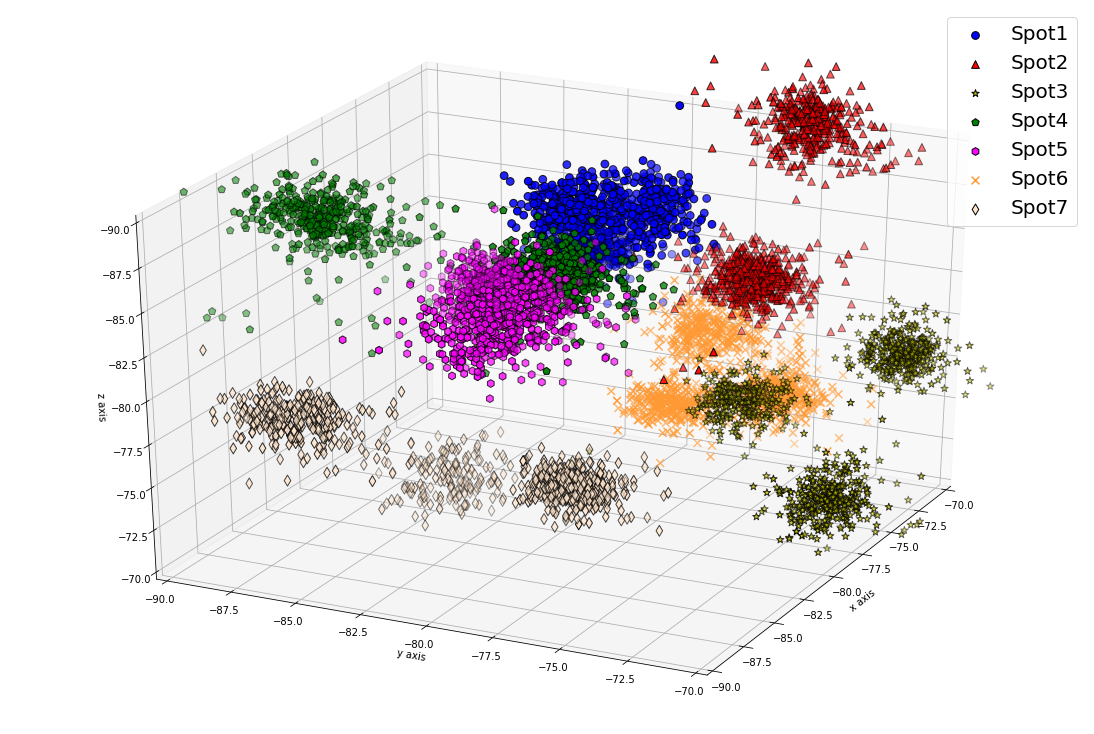

In [246]:
from mpl_toolkits.mplot3d import Axes3D, axes3d
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(15,10))
# ax = figure.add_subplot(111, projection='3d')
ax = Axes3D(figure, elev=-152, azim=-26)

area_name = ['Spot1','Spot2','Spot3','Spot4','Spot5','Spot6','Spot7']
# color = ['red','orange','green','black','blue','brown','purple']    
# marker = ['s','^','>','o','x','v','star']
size = 10

# ax.scatter(area1[0], area1[1], area1[2], label=area_name[0], s=size, color=color[0],marker=marker[0])
# ax.scatter(area2[0], area2[1], area2[2], label=area_name[1], s=size, color=color[1],marker=marker[1])
# ax.scatter(area3[0], area3[1], area3[2], label=area_name[2], s=size, color=color[2],marker=marker[2])
# ax.scatter(area4[0], area4[1], area4[2], label=area_name[3], s=size, color=color[3],marker=marker[3])
# ax.scatter(area5[0], area5[1], area5[2], label=area_name[4], s=size, color=color[4],marker=marker[4])
# ax.scatter(area6[0], area6[1], area6[2], label=area_name[5], s=size, color=color[5],marker=marker[5])
# ax.scatter(area7[0], area7[1], area7[2], label=area_name[6], s=size, color=color[6],marker=(5,1))

ax.scatter(area1[0], area1[1], area1[2], label=area_name[0], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area2[0], area2[1], area2[2], label=area_name[1], c='r', marker='^', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area3[0], area3[1], area3[2], label=area_name[2], c='y', marker='*', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area4[0], area4[1], area4[2], label=area_name[3], c='g', marker='p', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area5[0], area5[1], area5[2], label=area_name[4], c='#FF00FF', marker='h', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area6[0], area6[1], area6[2], label=area_name[5], c='#FF9933', marker='x', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area7[0], area7[1], area7[2], label=area_name[6], c='#FFE5CC', marker='d', cmap=mglearn.cm2, s=60, edgecolor='k')

params = {'legend.fontsize': 20,
          'legend.handlelength': 2,}

plt.rcParams.update(params)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

ax.set_xlim((-90, -70))
ax.set_ylim((-90, -70))
ax.set_zlim((-90, -70))

# plt.xlim(-100, -60)
# plt.ylim(-100, -60)
# plt.zlim(-100, -60)
ax.legend()

file_name = "C:\\Users\\lcs53\\OneDrive\\바탕 화면\\graph1.svg"
plt.savefig(file_name)

plt.show()

### (2) Coordinate Graph(After AutoEncoder)

In [247]:
set_num = 1000
# x_data = new_x_test_noisy
x_data = new_after_autoencoder_x_test

In [248]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_data_scaled = scaler.fit_transform(x_data)

In [249]:
# area = divide_area_value(x_data_scaled, set_num)
area = divide_area_value(x_data, set_num)

In [250]:
area[7].shape

(1000, 3)

In [251]:
area1 = convert_array_into_transpose(area[1], set_num)
area2 = convert_array_into_transpose(area[2], set_num)
area3 = convert_array_into_transpose(area[3], set_num)
area4 = convert_array_into_transpose(area[4], set_num)
area5 = convert_array_into_transpose(area[5], set_num)
area6 = convert_array_into_transpose(area[6], set_num)
area7 = convert_array_into_transpose(area[7], set_num)

In [252]:
np.array(area7).shape

(3, 1000)

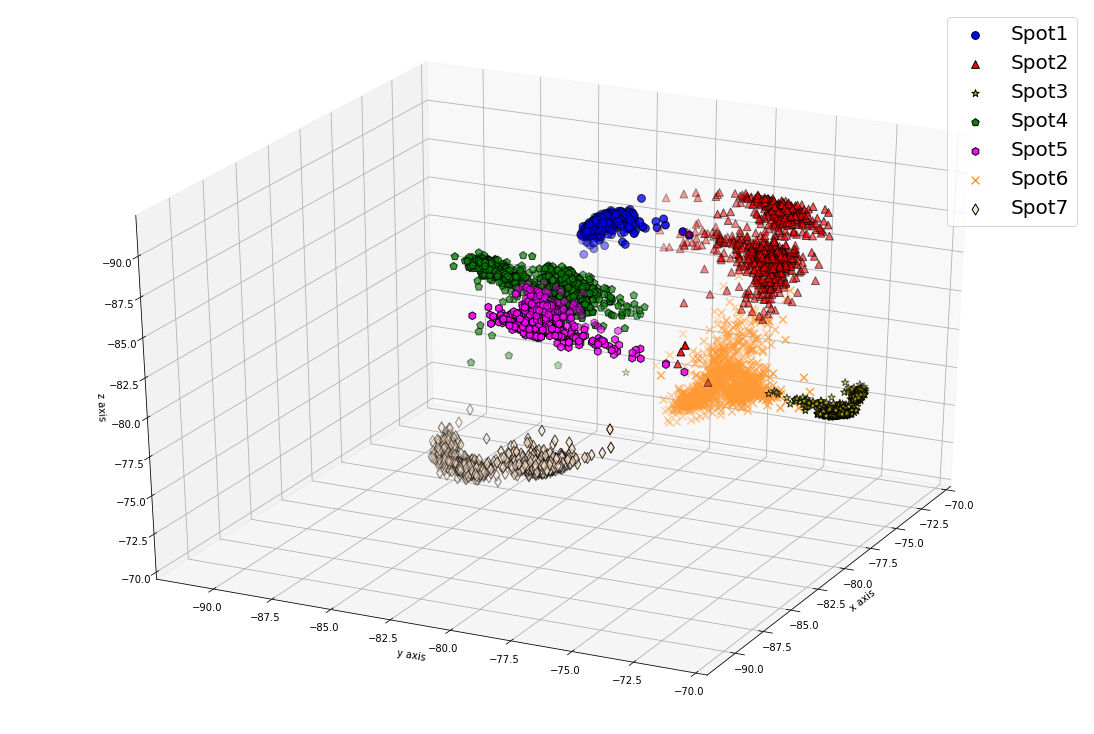

In [253]:
from mpl_toolkits.mplot3d import Axes3D, axes3d
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(15,10))
# ax = figure.add_subplot(111, projection='3d')
ax = Axes3D(figure, elev=-152, azim=-26)

area_name = ['Spot1','Spot2','Spot3','Spot4','Spot5','Spot6','Spot7']
# color = ['red','orange','green','black','blue','brown','purple']    
# marker = ['s','^','>','o','x','v','star']
size = 10

# ax.scatter(area1[0], area1[1], area1[2], label=area_name[0], s=size, color=color[0],marker=marker[0])
# ax.scatter(area2[0], area2[1], area2[2], label=area_name[1], s=size, color=color[1],marker=marker[1])
# ax.scatter(area3[0], area3[1], area3[2], label=area_name[2], s=size, color=color[2],marker=marker[2])
# ax.scatter(area4[0], area4[1], area4[2], label=area_name[3], s=size, color=color[3],marker=marker[3])
# ax.scatter(area5[0], area5[1], area5[2], label=area_name[4], s=size, color=color[4],marker=marker[4])
# ax.scatter(area6[0], area6[1], area6[2], label=area_name[5], s=size, color=color[5],marker=marker[5])
# ax.scatter(area7[0], area7[1], area7[2], label=area_name[6], s=size, color=color[6],marker=(5,1))

ax.scatter(area1[0], area1[1], area1[2], label=area_name[0], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area2[0], area2[1], area2[2], label=area_name[1], c='r', marker='^', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area3[0], area3[1], area3[2], label=area_name[2], c='y', marker='*', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area4[0], area4[1], area4[2], label=area_name[3], c='g', marker='p', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area5[0], area5[1], area5[2], label=area_name[4], c='#FF00FF', marker='h', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area6[0], area6[1], area6[2], label=area_name[5], c='#FF9933', marker='x', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(area7[0], area7[1], area7[2], label=area_name[6], c='#FFE5CC', marker='d', cmap=mglearn.cm2, s=60, edgecolor='k')

params = {'legend.fontsize': 20,
          'legend.handlelength': 2,}

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

ax.set_xlim((-92, -70))
ax.set_ylim((-92, -70))
ax.set_zlim((-92, -70))

# plt.xlim(-100, -60)
# plt.ylim(-100, -60)
# plt.zlim(-100, -60)
ax.legend()

file_name = "C:\\Users\\lcs53\\OneDrive\\바탕 화면\\graph2.svg"
plt.savefig(file_name)

plt.show()

### CSV file save test

In [ ]:
import pandas as pd
import numpy as np 
import codecs 

In [ ]:
def numpy_appender(path, item_numpy_list): 
    df = pd.DataFrame(item_numpy_list) 
    df.to_csv("tmp.csv",encoding='EUC-KR',header = False,index = False ) #temp.csv 에 numpylist저장 
    tmp_csv = pd.read_csv('tmp.csv',encoding='EUC-KR') #다시 읽어옴. 
    
    with codecs.open('nottmp.csv','a',encoding="EUC-KR") as f: 
        tmp_csv.to_csv(f,header=False,index = False)

def item_writer(localcode, timecode, local_name, path): 
    xml_string = query_sender(localcode,timecode) 
    item_list = xml_to_item_list(xml_string,local_name,time_code) 
    item_numpy_list = np.array(item_list) 
    numpy_appender(path, item_numpy_list)




# [Part 3] Car In/Out using sensors : Orientation, Magno

#### Method Definition

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

def read_data(state_num, case_num):
    base_dir = os.getcwd()
    test_data = np.loadtxt("C:\\Users\\lcs53\\PycharmProjects\\machine\\car2\\case"+str(state_num)+"_" +str(case_num)+ '.csv', delimiter=',', dtype=np.float32)
    return test_data

def read_result(state_num, case_num):
    base_dir = os.getcwd()
    test_data = np.loadtxt("C:\\Users\\lcs53\\PycharmProjects\\machine\\car2\\result"+str(state_num)+"_" +str(case_num)+ '.csv', delimiter=',', dtype=np.float32)
    return test_data

#### Data Reading

In [2]:
text1_title = "Car(Out → In)"
text2_title = "Car(In → Out)"

state_num = 1
case_num  = 10
test1_test_data = read_data(state_num, case_num)

state_num = 6
case_num  = 9
test2_test_data = read_data(state_num, case_num)

In [45]:
num = 4
test1_test_data = np.loadtxt("C:\\Users\\lcs53\\PycharmProjects\\machine\\car3\\caradd"+"_" + str(num) + ".csv", delimiter=',', dtype=np.float32)         

## 1. Sensor data

#### 1) car (out → in)

In [46]:
test1_x = test1_test_data[:, 0:1]

# title = "Orientation sensor "
# y1 = test_data[:, 4:5]
# test1_y2 = test1_test_data[:, 5:6]
# y3 = test_data[:, 6:7]

# title = "Magno sensor "
test1_y1 = test1_test_data[:, 10:11]
# y2 = test_data[:, 11:12]
# y3 = test_data[:, 12:13]

#### 2) car (in → out)

In [47]:
test2_x = test2_test_data[:, 0:1]
test2_y1 = test2_test_data[:, 10:11]

## 2. Generate Graph

#### 1) car (out → in)

In [48]:
# # plt.axis([0, 40])
# fig, ax1 = plt.subplots()

# # Magno x-axis (left)
# color = 'tab:red'
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('Magno x-axis', color=color)
# ax1.plot(test1_x, test1_y1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# # Orientation y-axis (right)
# color = 'tab:blue'
# ax2.set_ylabel('Orientation y-axis', color=color)  # we already handled the x-label with ax1
# ax2.plot(test1_x, test1_y2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.title(text1_title)
# plt.show()

In [49]:
test1_x.shape

(2250, 1)

In [50]:
tmp = test1_x[:2200,0]

In [51]:
tmp = tmp.reshape(2200,1)

In [52]:
tmp.shape

(2200, 1)

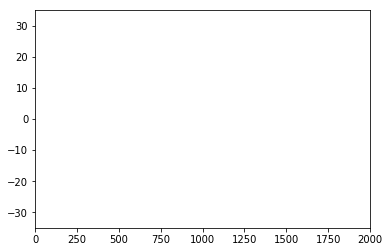

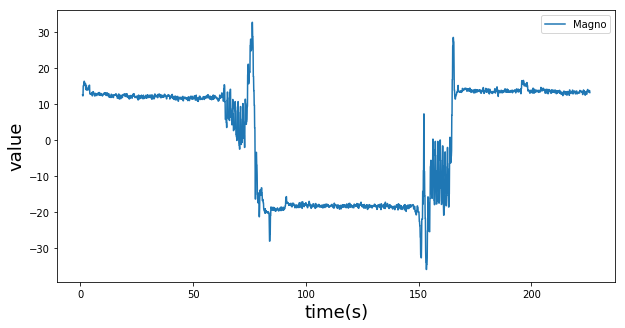

In [55]:
plt.axis([0, 2000, -35,35])
# title = "Magnetic sensor "
state = "(Out → In → Out)"
# plt.title(title+state)
x = test1_x
y1 =test1_y1
fig = plt.figure(figsize=(10, 5))
plt.plot(x, y1, label="Magno")

ax = fig.add_subplot(111)
# ax.xaxis.set_ticks([0.,100.,200.,300.,400.,500.,600.,700.,800.,900.,1000.,1100.,1200.,1300.,1400.,1500.,1600.,1700.,1800.,1900.,2000.])
# ax.xaxis.set_ticks([0.,250., 500.,750.,1000.,1250.,1500.,1750.,2000., 2250.])
ax.grid(False)

# plt.grid(5)
plt.legend()
plt.xlabel("time(s)", fontsize=18)
plt.ylabel("value", fontsize=18)

file_name = "C:\\Users\\lcs53\\OneDrive\\바탕 화면\\last.svg"
plt.savefig(file_name)

plt.show()

In [8]:
# import numpy as np
# import matplotlib.pyplot as plt

# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1)

# # Major ticks every 20, minor ticks every 5
# major_ticks = np.arange(0, 101, 20)
# minor_ticks = np.arange(0, 101, 5)

# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)

# # And a corresponding grid
# ax.grid(which='both')

# # Or if you want different settings for the grids:
# # ax.grid(which='minor', alpha=0.2)
# ax.grid(which='major', alpha=0.5)

# plt.show()

#### 2) car (in → out)

In [51]:
# # plt.axis([0, 60, -50,50])
# fig, ax1 = plt.subplots()

# # Magno x-axis (left)
# color = 'tab:red'
# ax1.set_xlabel('time (s)')
# ax1.set_ylabel('Magno x-axis', color=color)
# ax1.plot(test2_x, test2_y1, color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# # Orientation y-axis (right)
# color = 'tab:blue'
# ax2.set_ylabel('Orientation y-axis', color=color)  # we already handled the x-label with ax1
# ax2.plot(test2_x, test2_y2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.title(text2_title)
# plt.show()

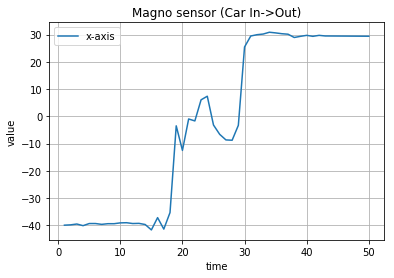

In [256]:
# plt.axis([0, 60, -50,50])
title = "Magno sensor "
state = "(Car In->Out)"
plt.title(title+state)
x = test2_x
y1 =test2_y1
plt.plot(x, y1, label="x-axis")
# plt.plot(x, y2, label="y-axis")
# plt.plot(x, y3, label="z-axis")

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("value")

file_name = "C:\\Users\\lcs53\\PycharmProjects\\test\\database\\training\\car_out\\car2.png"
plt.savefig(file_name)

plt.show()

#### (3) CNN model

* Input data Preprocessing

In [155]:
state_num = 1
case_num  = 2
test1_test_data = read_data(state_num, case_num)

state_num = 6
case_num  = 7
test2_test_data = read_data(state_num, case_num)

In [157]:
begin = 0
end   = 50

# time
test1_x = test1_test_data[begin:end, 0:1]

# # Orientation
# test1_ori = test1_test_data[begin:end, 5:6]

# Magnetic
test1_magno = test1_test_data[begin:end, 10:11]

In [158]:
print(test1_x.shape)
# print(test1_ori.shape)
print(test1_magno.shape)

(50, 1)
(50, 1)


In [159]:
# def input_data_preprocessing(test_x, test_ori, test_magno, filter, begin, end):
#     val1 = test_ori[begin: end]
#     val2 = test_magno[begin : end]
#     val = np.hstack([val1, val2])
#     val = np.ravel(val, order = 'C')
#     val = val.reshape(1,20)

#     return val

# def convert_array_into_list(data):
#     data = data.tolist()
        
#     return data

In [160]:
# print(input_data_preprocessing(test1_x, test1_ori, test1_magno, filter, 0, 10).shape)

In [161]:
# def merge_data(test_x, test_ori, test_magno, filter):
#     tmp = []
#     tmp = input_data_preprocessing(test_x, test_ori, test_magno, filter, 0, 10)
#     tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_ori, test_magno, filter, 10, 20)])
#     tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_ori, test_magno, filter, 20, 30)])
#     tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_ori, test_magno, filter, 30, 40)])
#     tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_ori, test_magno, filter, 40, 50)])
# #     tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_ori, test_magno, filter, 50, 60)])
    
#     return tmp

In [162]:
# tmp = merge_data(test1_x, test1_ori, test1_magno, filter)

In [163]:
# print(tmp.shape)

In [164]:
test1_magno.shape

(50, 1)

In [165]:
def input_data_preprocessing(test_x, test_magno, filter, begin, end):
    val = test_magno[begin : end]
    val = np.ravel(val, order = 'C')
    val = val.reshape(1, filter)
    return val

In [166]:
test1_x.shape

(50, 1)

In [167]:
test1_magno.shape

(50, 1)

In [178]:
filter = 5
def merge_data(test_x, test_magno, filter):
    tmp = input_data_preprocessing(test_x, test1_magno, filter, 0, 5)
    tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_magno, filter,  5, 10)])
    tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_magno, filter, 10, 15)])
    tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_magno, filter, 15, 20)])
    tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_magno, filter, 20, 25)])
    tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_magno, filter, 25, 30)])
    tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_magno, filter, 30, 35)])
    tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_magno, filter, 35, 40)])
    tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_magno, filter, 40, 45)])
    tmp = np.vstack([tmp, input_data_preprocessing(test_x, test_magno, filter, 45, 50)])
    
    return tmp

In [179]:
state_num = 1
case_num  = 1

def divide_sensor_input(state_num, case_num):
    test1_test_data = read_data(state_num, case_num)

    test1_x = test1_test_data[:, 0:1]
    test1_y1 = test1_test_data[:, 10:11]
    
    return test1_x, test1_y1

def divide_sensor_output(state_num, case_num):
    test1_test_data = read_result(state_num, case_num)
    result = test1_test_data[:, 0:1]
    
    return result

In [180]:
_,file_1_x = divide_sensor_input(1,1)
_,file_2_x = divide_sensor_input(1,2)
_,file_3_x = divide_sensor_input(1,3)
_,file_4_x = divide_sensor_input(1,4)
_,file_5_x = divide_sensor_input(1,5)
_,file_6_x = divide_sensor_input(1,6)
_,file_7_x = divide_sensor_input(1,7)
_,file_8_x = divide_sensor_input(1,8)
_,file_9_x = divide_sensor_input(1,9)
_,file_10_x = divide_sensor_input(1,10)

input_1_x = merge_data(test1_x, file_1_x, filter)
input_2_x = merge_data(test1_x, file_2_x, filter)
input_3_x = merge_data(test1_x, file_3_x, filter)
input_4_x = merge_data(test1_x, file_4_x, filter)
input_5_x = merge_data(test1_x, file_5_x, filter)
input_6_x = merge_data(test1_x, file_6_x, filter)
input_7_x = merge_data(test1_x, file_7_x, filter)
input_8_x = merge_data(test1_x, file_8_x, filter)
input_9_x = merge_data(test1_x, file_9_x, filter)
input_10_x = merge_data(test1_x, file_10_x, filter)

In [181]:
file_1_x.shape

(50, 1)

In [182]:
test1_x.shape

(50, 1)

In [183]:
input_1_x

array([[  7.5      ,   8.76     ,   8.5199995,   7.2599998,   7.3799996],
       [  2.34     ,   4.44     ,  -1.56     ,   4.44     ,  -1.56     ],
       [  4.44     ,  -1.56     ,  -9.66     ,  14.04     ,  35.88     ],
       [ -1.26     , -16.26     , -32.219997 , -28.74     , -33.48     ],
       [-34.98     , -35.579998 , -35.52     , -35.34     , -35.399998 ],
       [-35.219997 , -35.399998 , -34.68     , -35.1      , -34.62     ],
       [-35.399998 , -34.98     , -35.219997 , -35.76     , -35.28     ],
       [-35.82     , -35.399998 , -35.219997 , -35.88     , -33.       ],
       [-34.02     , -34.079998 , -34.98     , -35.64     , -35.76     ],
       [-37.02     , -37.41     , -38.034    , -38.658    , -39.282    ]],
      dtype=float32)

In [184]:
input_1_x.shape

(10, 5)

In [185]:
tmp = input_1_x
tmp = np.vstack([tmp, input_2_x])
tmp = np.vstack([tmp, input_3_x])
tmp = np.vstack([tmp, input_4_x])
tmp = np.vstack([tmp, input_5_x])
tmp = np.vstack([tmp, input_6_x])
tmp = np.vstack([tmp, input_7_x])
tmp = np.vstack([tmp, input_8_x])
tmp = np.vstack([tmp, input_9_x])
tmp = np.vstack([tmp, input_10_x])

In [186]:
tmp.shape

(100, 5)

In [187]:
input_data = tmp

In [188]:
file_1_y = divide_sensor_output(6,1)
file_2_y = divide_sensor_output(6,2)
file_3_y = divide_sensor_output(6,3)
file_4_y = divide_sensor_output(6,4)
file_5_y = divide_sensor_output(6,5)
file_6_y = divide_sensor_output(6,6)
file_7_y = divide_sensor_output(6,7)
file_8_y = divide_sensor_output(6,8)
file_9_y = divide_sensor_output(6,9)
file_10_y = divide_sensor_output(6,10)

In [189]:
file_1_y.shape

(10, 1)

In [190]:
tmp = file_1_y
tmp = np.vstack([tmp, file_2_y])
tmp = np.vstack([tmp, file_3_y])
tmp = np.vstack([tmp, file_4_y])
tmp = np.vstack([tmp, file_5_y])
tmp = np.vstack([tmp, file_6_y])
tmp = np.vstack([tmp, file_7_y])
tmp = np.vstack([tmp, file_8_y])
tmp = np.vstack([tmp, file_9_y])
tmp = np.vstack([tmp, file_10_y])

In [191]:
tmp.shape

(100, 1)

In [192]:
output_data = tmp

In [193]:
input_data.shape

(100, 5)

In [194]:
output_data.shape

(100, 1)

In [195]:
x_data, y_data = input_data, output_data

In [196]:
x_data.shape

(100, 5)

In [197]:
y_data.shape

(100, 1)

In [207]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.utils import np_utils
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import MaxPooling1D


x_data, y_data = input_data, output_data

x_data = x_data.reshape(100, 5, 1)  #넘파이행렬로 변환 : 행, 열, 1차원
#y_data = y_data.reshape(8995,51,1)
model = Sequential()
model.add(Conv1D(128,3,activation='sigmoid', input_shape = (5,1), padding = 'same', strides = 1))
#필터갯수,필터크기,활성함수,(입력갯수=열,행), 패딩:same(입,출력 크기 동일)/valid(패딩x),stride(건너뛰기)
# model.add(Conv1D(128,3,activation='sigmoid'))
# model.add(MaxPooling1D(3))  #3칸마다 가장 큰 찾기
# model.add(Conv1D(64,3,activation='sigmoid'))
# model.add(Conv1D(64,3,activation='sigmoid'))
model.add(GlobalAveragePooling1D()) #각 차원마다 평균값 도출
model.add(Dropout(0.5)) #비활성화(0.1), 활성화(0.9)
model.add(Dense(1, activation = 'sigmoid')) #신경망비슷

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.fit(x_data, y_data, batch_size = 100, epochs = 3000)

Epoch 1/3000
100/100 [==============================] - 0s 5ms/step - loss: 0.9709 - acc: 0.3900
Epoch 2/3000
100/100 [==============================] - 0s 30us/step - loss: 0.8159 - acc: 0.4200
Epoch 3/3000
100/100 [==============================] - 0s 35us/step - loss: 0.8263 - acc: 0.4900
Epoch 4/3000
100/100 [==============================] - 0s 35us/step - loss: 0.6811 - acc: 0.5700
Epoch 5/3000
100/100 [==============================] - 0s 35us/step - loss: 0.6372 - acc: 0.6400
Epoch 6/3000
100/100 [==============================] - 0s 35us/step - loss: 0.6205 - acc: 0.6000
Epoch 7/3000
100/100 [==============================] - 0s 35us/step - loss: 0.5455 - acc: 0.6900
Epoch 8/3000
100/100 [==============================] - 0s 45us/step - loss: 0.5347 - acc: 0.7800
Epoch 9/3000
100/100 [==============================] - 0s 50us/step - loss: 0.5541 - acc: 0.6800
Epoch 10/3000
100/100 [==============================] - 0s 40us/step - loss: 0.5645 - acc: 0.7100
Epoch 11/3000
100/10

Epoch 84/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3551 - acc: 0.8000
Epoch 85/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3931 - acc: 0.8100
Epoch 86/3000
100/100 [==============================] - 0s 50us/step - loss: 0.4001 - acc: 0.8000
Epoch 87/3000
100/100 [==============================] - 0s 55us/step - loss: 0.4126 - acc: 0.7900
Epoch 88/3000
100/100 [==============================] - 0s 50us/step - loss: 0.3820 - acc: 0.8100
Epoch 89/3000
100/100 [==============================] - 0s 55us/step - loss: 0.3758 - acc: 0.8200
Epoch 90/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3496 - acc: 0.8100
Epoch 91/3000
100/100 [==============================] - 0s 44us/step - loss: 0.3816 - acc: 0.8300
Epoch 92/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3476 - acc: 0.8300
Epoch 93/3000
100/100 [==============================] - 0s 54us/step - loss: 0.3661 - acc: 0.8500
Epoch 94/3

Epoch 167/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3910 - acc: 0.7800
Epoch 168/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3964 - acc: 0.8100
Epoch 169/3000
100/100 [==============================] - 0s 25us/step - loss: 0.3623 - acc: 0.8300
Epoch 170/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3620 - acc: 0.8000
Epoch 171/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3559 - acc: 0.8500
Epoch 172/3000
100/100 [==============================] - 0s 50us/step - loss: 0.3662 - acc: 0.7900
Epoch 173/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3594 - acc: 0.8400
Epoch 174/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3823 - acc: 0.8000
Epoch 175/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3364 - acc: 0.8700
Epoch 176/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3579 - acc: 0.8100


Epoch 249/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3242 - acc: 0.8300
Epoch 250/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3464 - acc: 0.8300
Epoch 251/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3453 - acc: 0.8100
Epoch 252/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3401 - acc: 0.8400
Epoch 253/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3384 - acc: 0.8300
Epoch 254/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3302 - acc: 0.8500
Epoch 255/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3701 - acc: 0.8200
Epoch 256/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3529 - acc: 0.8300
Epoch 257/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3781 - acc: 0.8000
Epoch 258/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3305 - acc: 0.8200


Epoch 331/3000
100/100 [==============================] - 0s 25us/step - loss: 0.3666 - acc: 0.8300
Epoch 332/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3449 - acc: 0.8100
Epoch 333/3000
100/100 [==============================] - 0s 50us/step - loss: 0.3782 - acc: 0.8200
Epoch 334/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3135 - acc: 0.8300
Epoch 335/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3450 - acc: 0.8200
Epoch 336/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3340 - acc: 0.8300
Epoch 337/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3477 - acc: 0.8300
Epoch 338/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3634 - acc: 0.8300
Epoch 339/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3443 - acc: 0.8100
Epoch 340/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3536 - acc: 0.8500


Epoch 413/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3693 - acc: 0.8400
Epoch 414/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3311 - acc: 0.8500
Epoch 415/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3304 - acc: 0.8000
Epoch 416/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3450 - acc: 0.8100
Epoch 417/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3123 - acc: 0.8500
Epoch 418/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3545 - acc: 0.8300
Epoch 419/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3381 - acc: 0.8300
Epoch 420/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3303 - acc: 0.8200
Epoch 421/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3935 - acc: 0.8100
Epoch 422/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3321 - acc: 0.8500


Epoch 495/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3299 - acc: 0.8500
Epoch 496/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3698 - acc: 0.8100
Epoch 497/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3241 - acc: 0.8500
Epoch 498/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3668 - acc: 0.7900
Epoch 499/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3407 - acc: 0.8500
Epoch 500/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3280 - acc: 0.8400
Epoch 501/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3487 - acc: 0.7900
Epoch 502/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3340 - acc: 0.8400
Epoch 503/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3438 - acc: 0.8400
Epoch 504/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3374 - acc: 0.8200


Epoch 577/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3344 - acc: 0.8300
Epoch 578/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3454 - acc: 0.8400
Epoch 579/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3287 - acc: 0.8100
Epoch 580/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3702 - acc: 0.7900
Epoch 581/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3150 - acc: 0.8500
Epoch 582/3000
100/100 [==============================] - 0s 44us/step - loss: 0.3206 - acc: 0.8400
Epoch 583/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3433 - acc: 0.8400
Epoch 584/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3233 - acc: 0.8400
Epoch 585/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3375 - acc: 0.8300
Epoch 586/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3321 - acc: 0.8100


Epoch 659/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3634 - acc: 0.8400
Epoch 660/3000
100/100 [==============================] - 0s 50us/step - loss: 0.3440 - acc: 0.8300
Epoch 661/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3312 - acc: 0.8500
Epoch 662/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3460 - acc: 0.8300
Epoch 663/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3352 - acc: 0.8400
Epoch 664/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3352 - acc: 0.8200
Epoch 665/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3164 - acc: 0.8800
Epoch 666/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3377 - acc: 0.8100
Epoch 667/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3200 - acc: 0.8400
Epoch 668/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2942 - acc: 0.8500


Epoch 741/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3207 - acc: 0.8200
Epoch 742/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3453 - acc: 0.8300
Epoch 743/3000
100/100 [==============================] - 0s 50us/step - loss: 0.3272 - acc: 0.8300
Epoch 744/3000
100/100 [==============================] - 0s 50us/step - loss: 0.3031 - acc: 0.8600
Epoch 745/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3193 - acc: 0.8500
Epoch 746/3000
100/100 [==============================] - 0s 49us/step - loss: 0.3255 - acc: 0.8300
Epoch 747/3000
100/100 [==============================] - 0s 54us/step - loss: 0.3376 - acc: 0.8300
Epoch 748/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3129 - acc: 0.8400
Epoch 749/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3585 - acc: 0.8100
Epoch 750/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2955 - acc: 0.8600


Epoch 823/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3080 - acc: 0.8700
Epoch 824/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3230 - acc: 0.8600
Epoch 825/3000
100/100 [==============================] - 0s 39us/step - loss: 0.3188 - acc: 0.8500
Epoch 826/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3231 - acc: 0.8400
Epoch 827/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3436 - acc: 0.8300
Epoch 828/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3312 - acc: 0.8500
Epoch 829/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3548 - acc: 0.8000
Epoch 830/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3278 - acc: 0.8500
Epoch 831/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3234 - acc: 0.8000
Epoch 832/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3252 - acc: 0.8400


Epoch 905/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3346 - acc: 0.8400
Epoch 906/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3037 - acc: 0.8600
Epoch 907/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3215 - acc: 0.8700
Epoch 908/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3442 - acc: 0.8100
Epoch 909/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3271 - acc: 0.8500
Epoch 910/3000
100/100 [==============================] - 0s 50us/step - loss: 0.2837 - acc: 0.8600
Epoch 911/3000
100/100 [==============================] - 0s 60us/step - loss: 0.3151 - acc: 0.8400
Epoch 912/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3639 - acc: 0.8000
Epoch 913/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2897 - acc: 0.8600
Epoch 914/3000
100/100 [==============================] - 0s 50us/step - loss: 0.2602 - acc: 0.8600


Epoch 987/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3411 - acc: 0.8200
Epoch 988/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3161 - acc: 0.8500
Epoch 989/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3041 - acc: 0.8800
Epoch 990/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2909 - acc: 0.8700
Epoch 991/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3069 - acc: 0.8100
Epoch 992/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3031 - acc: 0.8400
Epoch 993/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2922 - acc: 0.8400
Epoch 994/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3146 - acc: 0.8400
Epoch 995/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2945 - acc: 0.8400
Epoch 996/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3309 - acc: 0.8300


Epoch 1069/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2842 - acc: 0.8900
Epoch 1070/3000
100/100 [==============================] - 0s 25us/step - loss: 0.2950 - acc: 0.8400
Epoch 1071/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2836 - acc: 0.8700
Epoch 1072/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3110 - acc: 0.8400
Epoch 1073/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3278 - acc: 0.8300
Epoch 1074/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3583 - acc: 0.8200
Epoch 1075/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2743 - acc: 0.8400
Epoch 1076/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3310 - acc: 0.8100
Epoch 1077/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2784 - acc: 0.8900
Epoch 1078/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2778 - ac

Epoch 1151/3000
100/100 [==============================] - 0s 25us/step - loss: 0.3231 - acc: 0.8300
Epoch 1152/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3172 - acc: 0.8300
Epoch 1153/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3039 - acc: 0.8600
Epoch 1154/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3461 - acc: 0.8100
Epoch 1155/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2949 - acc: 0.8400
Epoch 1156/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2809 - acc: 0.8900
Epoch 1157/3000
100/100 [==============================] - 0s 25us/step - loss: 0.2909 - acc: 0.8400
Epoch 1158/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2973 - acc: 0.8700
Epoch 1159/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3152 - acc: 0.8100
Epoch 1160/3000
100/100 [==============================] - 0s 55us/step - loss: 0.3030 - ac

Epoch 1233/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3440 - acc: 0.8300
Epoch 1234/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3370 - acc: 0.8300
Epoch 1235/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3403 - acc: 0.8000
Epoch 1236/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3025 - acc: 0.8400
Epoch 1237/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3003 - acc: 0.8500
Epoch 1238/3000
100/100 [==============================] - 0s 50us/step - loss: 0.3270 - acc: 0.8500
Epoch 1239/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3108 - acc: 0.8300
Epoch 1240/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3035 - acc: 0.8100
Epoch 1241/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3021 - acc: 0.8600
Epoch 1242/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3210 - ac

Epoch 1315/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3211 - acc: 0.8400
Epoch 1316/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2945 - acc: 0.8400
Epoch 1317/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3027 - acc: 0.8600
Epoch 1318/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2907 - acc: 0.8700
Epoch 1319/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2994 - acc: 0.8500
Epoch 1320/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3020 - acc: 0.8500
Epoch 1321/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3095 - acc: 0.8500
Epoch 1322/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3363 - acc: 0.8000
Epoch 1323/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3218 - acc: 0.8700
Epoch 1324/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3537 - ac

Epoch 1397/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3066 - acc: 0.8400
Epoch 1398/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3027 - acc: 0.8800
Epoch 1399/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3095 - acc: 0.8300
Epoch 1400/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3188 - acc: 0.8400
Epoch 1401/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3375 - acc: 0.8400
Epoch 1402/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3057 - acc: 0.8500
Epoch 1403/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2749 - acc: 0.8500
Epoch 1404/3000
100/100 [==============================] - 0s 25us/step - loss: 0.3140 - acc: 0.8300
Epoch 1405/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3084 - acc: 0.8500
Epoch 1406/3000
100/100 [==============================] - 0s 55us/step - loss: 0.2955 - ac

Epoch 1479/3000
100/100 [==============================] - 0s 50us/step - loss: 0.2670 - acc: 0.8800
Epoch 1480/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3024 - acc: 0.8600
Epoch 1481/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3096 - acc: 0.8500
Epoch 1482/3000
100/100 [==============================] - 0s 50us/step - loss: 0.3060 - acc: 0.8300
Epoch 1483/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2930 - acc: 0.8800
Epoch 1484/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3030 - acc: 0.8800
Epoch 1485/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2869 - acc: 0.8300
Epoch 1486/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3177 - acc: 0.8500
Epoch 1487/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3261 - acc: 0.8400
Epoch 1488/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3117 - ac

Epoch 1561/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2489 - acc: 0.9000
Epoch 1562/3000
100/100 [==============================] - 0s 50us/step - loss: 0.3228 - acc: 0.8600
Epoch 1563/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2734 - acc: 0.8700
Epoch 1564/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2968 - acc: 0.8300
Epoch 1565/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3179 - acc: 0.8400
Epoch 1566/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3300 - acc: 0.8200
Epoch 1567/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2985 - acc: 0.8500
Epoch 1568/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3038 - acc: 0.8400
Epoch 1569/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2772 - acc: 0.8700
Epoch 1570/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2905 - ac

Epoch 1643/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2627 - acc: 0.8800
Epoch 1644/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3081 - acc: 0.8600
Epoch 1645/3000
100/100 [==============================] - 0s 55us/step - loss: 0.2871 - acc: 0.8600
Epoch 1646/3000
100/100 [==============================] - 0s 50us/step - loss: 0.2614 - acc: 0.8700
Epoch 1647/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3280 - acc: 0.8500
Epoch 1648/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3102 - acc: 0.8400
Epoch 1649/3000
100/100 [==============================] - 0s 45us/step - loss: 0.3025 - acc: 0.8400
Epoch 1650/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2558 - acc: 0.8800
Epoch 1651/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3321 - acc: 0.8300
Epoch 1652/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2997 - ac

Epoch 1725/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2889 - acc: 0.8600
Epoch 1726/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2723 - acc: 0.8800
Epoch 1727/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2886 - acc: 0.8400
Epoch 1728/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2768 - acc: 0.8400
Epoch 1729/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3407 - acc: 0.8500
Epoch 1730/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3244 - acc: 0.8100
Epoch 1731/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2969 - acc: 0.8500
Epoch 1732/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3313 - acc: 0.8400
Epoch 1733/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2645 - acc: 0.8600
Epoch 1734/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3210 - ac

Epoch 1807/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2806 - acc: 0.8700
Epoch 1808/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2581 - acc: 0.8800
Epoch 1809/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2750 - acc: 0.8500
Epoch 1810/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2862 - acc: 0.8800
Epoch 1811/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2732 - acc: 0.8600
Epoch 1812/3000
100/100 [==============================] - 0s 55us/step - loss: 0.2747 - acc: 0.8800
Epoch 1813/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2815 - acc: 0.8700
Epoch 1814/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2485 - acc: 0.9000
Epoch 1815/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2559 - acc: 0.8800
Epoch 1816/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3047 - ac

Epoch 1889/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3050 - acc: 0.8700
Epoch 1890/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2949 - acc: 0.8800
Epoch 1891/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3089 - acc: 0.8900
Epoch 1892/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2848 - acc: 0.8800
Epoch 1893/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2996 - acc: 0.8500
Epoch 1894/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2923 - acc: 0.8500
Epoch 1895/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2864 - acc: 0.8500
Epoch 1896/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2847 - acc: 0.8600
Epoch 1897/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2886 - acc: 0.8800
Epoch 1898/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2972 - ac

Epoch 1971/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2878 - acc: 0.8600
Epoch 1972/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2860 - acc: 0.8300
Epoch 1973/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2910 - acc: 0.8500
Epoch 1974/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2870 - acc: 0.8500
Epoch 1975/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2674 - acc: 0.8800
Epoch 1976/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2707 - acc: 0.8900
Epoch 1977/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2728 - acc: 0.9100
Epoch 1978/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2820 - acc: 0.8500
Epoch 1979/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3142 - acc: 0.8400
Epoch 1980/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2790 - ac

100/100 [==============================] - 0s 55us/step - loss: 0.2746 - acc: 0.8900
Epoch 2053/3000
100/100 [==============================] - 0s 25us/step - loss: 0.2958 - acc: 0.8600
Epoch 2054/3000
100/100 [==============================] - 0s 25us/step - loss: 0.2671 - acc: 0.8900
Epoch 2055/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2588 - acc: 0.8800
Epoch 2056/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2721 - acc: 0.8500
Epoch 2057/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2672 - acc: 0.8700
Epoch 2058/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2812 - acc: 0.8400
Epoch 2059/3000
100/100 [==============================] - 0s 40us/step - loss: 0.3045 - acc: 0.8800
Epoch 2060/3000
100/100 [==============================] - 0s 55us/step - loss: 0.2491 - acc: 0.9000
Epoch 2061/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2733 - acc: 0.8600
Epoch 

Epoch 2134/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2612 - acc: 0.8900
Epoch 2135/3000
100/100 [==============================] - 0s 35us/step - loss: 0.3059 - acc: 0.8500
Epoch 2136/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2759 - acc: 0.8600
Epoch 2137/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2623 - acc: 0.9000
Epoch 2138/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2638 - acc: 0.8700
Epoch 2139/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2460 - acc: 0.8800
Epoch 2140/3000
100/100 [==============================] - 0s 50us/step - loss: 0.2733 - acc: 0.8600
Epoch 2141/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2823 - acc: 0.8700
Epoch 2142/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2838 - acc: 0.8600
Epoch 2143/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2981 - ac

Epoch 2216/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2559 - acc: 0.8800
Epoch 2217/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2508 - acc: 0.8900
Epoch 2218/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2582 - acc: 0.8700
Epoch 2219/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2734 - acc: 0.9000
Epoch 2220/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2827 - acc: 0.8600
Epoch 2221/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2474 - acc: 0.8700
Epoch 2222/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2916 - acc: 0.8500
Epoch 2223/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2861 - acc: 0.8700
Epoch 2224/3000
100/100 [==============================] - 0s 50us/step - loss: 0.2856 - acc: 0.8700
Epoch 2225/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2350 - ac

Epoch 2298/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2819 - acc: 0.8600
Epoch 2299/3000
100/100 [==============================] - 0s 55us/step - loss: 0.2564 - acc: 0.8800
Epoch 2300/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2707 - acc: 0.8700
Epoch 2301/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2683 - acc: 0.8900
Epoch 2302/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2772 - acc: 0.8500
Epoch 2303/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2627 - acc: 0.8900
Epoch 2304/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2810 - acc: 0.8600
Epoch 2305/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2636 - acc: 0.8900
Epoch 2306/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2535 - acc: 0.8500
Epoch 2307/3000
100/100 [==============================] - 0s 50us/step - loss: 0.2782 - ac

Epoch 2380/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2389 - acc: 0.8800
Epoch 2381/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2694 - acc: 0.8700
Epoch 2382/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3246 - acc: 0.8600
Epoch 2383/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2505 - acc: 0.8800
Epoch 2384/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2727 - acc: 0.8800
Epoch 2385/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2792 - acc: 0.8600
Epoch 2386/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2855 - acc: 0.8600
Epoch 2387/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2476 - acc: 0.8900
Epoch 2388/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2716 - acc: 0.8600
Epoch 2389/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3024 - ac

Epoch 2462/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2883 - acc: 0.8600
Epoch 2463/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2535 - acc: 0.8900
Epoch 2464/3000
100/100 [==============================] - 0s 25us/step - loss: 0.2510 - acc: 0.9000
Epoch 2465/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2534 - acc: 0.9100
Epoch 2466/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3096 - acc: 0.8600
Epoch 2467/3000
100/100 [==============================] - 0s 25us/step - loss: 0.2778 - acc: 0.8600
Epoch 2468/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3151 - acc: 0.8600
Epoch 2469/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2723 - acc: 0.8800
Epoch 2470/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2685 - acc: 0.8800
Epoch 2471/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2879 - ac

Epoch 2544/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2676 - acc: 0.8900
Epoch 2545/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2402 - acc: 0.8700
Epoch 2546/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2337 - acc: 0.8900
Epoch 2547/3000
100/100 [==============================] - 0s 30us/step - loss: 0.3024 - acc: 0.8600
Epoch 2548/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2560 - acc: 0.8800
Epoch 2549/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2760 - acc: 0.8800
Epoch 2550/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2728 - acc: 0.8900
Epoch 2551/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2990 - acc: 0.8600
Epoch 2552/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2798 - acc: 0.8700
Epoch 2553/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2682 - ac

Epoch 2626/3000
100/100 [==============================] - 0s 60us/step - loss: 0.2703 - acc: 0.8700
Epoch 2627/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2685 - acc: 0.8900
Epoch 2628/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2647 - acc: 0.8800
Epoch 2629/3000
100/100 [==============================] - 0s 50us/step - loss: 0.2744 - acc: 0.8700
Epoch 2630/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2943 - acc: 0.8500
Epoch 2631/3000
100/100 [==============================] - 0s 25us/step - loss: 0.2604 - acc: 0.9000
Epoch 2632/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2992 - acc: 0.8600
Epoch 2633/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2580 - acc: 0.8800
Epoch 2634/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2587 - acc: 0.9000
Epoch 2635/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2760 - ac

Epoch 2708/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2202 - acc: 0.9100
Epoch 2709/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2642 - acc: 0.8900
Epoch 2710/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2746 - acc: 0.8800
Epoch 2711/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2869 - acc: 0.8600
Epoch 2712/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2654 - acc: 0.8800
Epoch 2713/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2503 - acc: 0.9000
Epoch 2714/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2578 - acc: 0.8800
Epoch 2715/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2509 - acc: 0.8700
Epoch 2716/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2901 - acc: 0.8700
Epoch 2717/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2813 - ac

Epoch 2790/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2748 - acc: 0.8400
Epoch 2791/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2483 - acc: 0.8800
Epoch 2792/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2481 - acc: 0.8700
Epoch 2793/3000
100/100 [==============================] - 0s 50us/step - loss: 0.2522 - acc: 0.8700
Epoch 2794/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2292 - acc: 0.8700
Epoch 2795/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2724 - acc: 0.8900
Epoch 2796/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2512 - acc: 0.8900
Epoch 2797/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2402 - acc: 0.9000
Epoch 2798/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2796 - acc: 0.8500
Epoch 2799/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2536 - ac

Epoch 2872/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2706 - acc: 0.8700
Epoch 2873/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2660 - acc: 0.8900
Epoch 2874/3000
100/100 [==============================] - 0s 64us/step - loss: 0.2651 - acc: 0.9000
Epoch 2875/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2591 - acc: 0.8800
Epoch 2876/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2496 - acc: 0.8800
Epoch 2877/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2879 - acc: 0.8600
Epoch 2878/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2597 - acc: 0.8600
Epoch 2879/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2553 - acc: 0.8800
Epoch 2880/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2453 - acc: 0.9000
Epoch 2881/3000
100/100 [==============================] - 0s 50us/step - loss: 0.2647 - ac

Epoch 2954/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2652 - acc: 0.8700
Epoch 2955/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2976 - acc: 0.8800
Epoch 2956/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2557 - acc: 0.8900
Epoch 2957/3000
100/100 [==============================] - 0s 69us/step - loss: 0.2489 - acc: 0.8900
Epoch 2958/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2618 - acc: 0.8900
Epoch 2959/3000
100/100 [==============================] - 0s 45us/step - loss: 0.2049 - acc: 0.9400
Epoch 2960/3000
100/100 [==============================] - 0s 40us/step - loss: 0.2653 - acc: 0.8900
Epoch 2961/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2534 - acc: 0.8800
Epoch 2962/3000
100/100 [==============================] - 0s 35us/step - loss: 0.2724 - acc: 0.8700
Epoch 2963/3000
100/100 [==============================] - 0s 30us/step - loss: 0.2925 - ac

Test

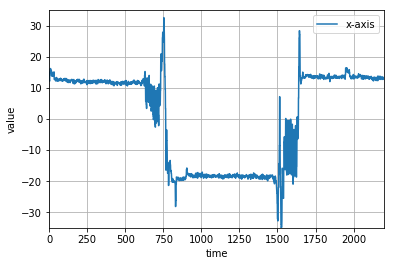

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

base_dir = "C:\\Users\\lcs53\\PycharmProjects\\machine"
# case = 1
num = 4
test_data = np.loadtxt(base_dir + "\\car3\\caradd" +"_" + str(num) + ".csv", delimiter=',', dtype=np.float32)
# title = "Magnetic sensor "

y1 = test_data[:, 10:11]

plt.axis([0, 2200, -35,35])

# plt.title(title)
x = test_data[:, 0:1]
plt.plot(x, y1, label="x-axis")

plt.grid()
plt.legend()
plt.xlabel("time")
plt.ylabel("value")

file_name = "C:\\Users\\lcs53\\OneDrive\\바탕 화면\\car_svm.svg"
plt.savefig(file_name)

plt.show()

#### 2차 실험(Car in/out)

In [269]:
import os
import numpy as np
import matplotlib.pyplot as plt

def input_data_preprocessing(test_x, test_magno, filter, begin, end):
    val = test_magno[begin : end]
    val = np.ravel(val, order = 'C')
    val = val.reshape(1, filter)
    return val

def read_input(state_num):
    base_dir = os.getcwd()
    test_data = np.loadtxt("C:\\Users\\lcs53\\PycharmProjects\\machine\\car3\\input_"+str(state_num)+'.csv', delimiter=',', dtype=np.float32)
    return test_data

def read_output(state_num):
    base_dir = os.getcwd()
    test_data = np.loadtxt("C:\\Users\\lcs53\\PycharmProjects\\machine\\car3\\output_"+str(state_num)+'.csv', delimiter=',', dtype=np.float32)
    return test_data

In [270]:
state_num0 = 0
state_num1 = 1
state_num2 = 2
input_data0 = read_input(state_num0)
input_data1 = read_input(state_num1)
input_data2 = read_input(state_num2)

In [271]:
state_num0 = 0
state_num1 = 1
state_num2 = 2
output_data0 = read_output(state_num0)
output_data1 = read_output(state_num1)
output_data2= read_output(state_num2)

In [272]:
input_data = np.vstack([input_data0,input_data1])
input_data = np.vstack([input_data, input_data2])

In [273]:
input_data  = input_data[:,10:11]

In [274]:
input_data.shape

(8200, 1)

In [275]:
output_data = np.vstack([output_data0,output_data1])
output_data = np.vstack([output_data ,output_data2])

In [276]:
output_data.shape

(8200, 3)

In [277]:
input_data = input_data.reshape(1640,5,1)

In [278]:
output_data=output_data.reshape(1640,15)

In [279]:
output_data=output_data[:,12:15]

In [280]:
import csv
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.utils import np_utils
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import MaxPooling1D


x_data, y_data = input_data, output_data

x_data = x_data.reshape(1640, 5, 1)  #넘파이행렬로 변환 : 행, 열, 1차원
#y_data = y_data.reshape(8995,51,1)
model = Sequential()
model.add(Conv1D(128,3,activation='relu', input_shape = (5,1), padding = 'same', strides = 1))
#필터갯수,필터크기,활성함수,(입력갯수=열,행), 패딩:same(입,출력 크기 동일)/valid(패딩x),stride(건너뛰기)
# model.add(Conv1D(128,3,activation='sigmoid'))
# model.add(MaxPooling1D(3))  #3칸마다 가장 큰 찾기
# model.add(Conv1D(64,3,activation='sigmoid'))
# model.add(Conv1D(64,3,activation='sigmoid'))
model.add(GlobalAveragePooling1D()) #각 차원마다 평균값 도출
model.add(Dropout(0.5)) #비활성화(0.1), 활성화(0.9)
model.add(Dense(3, activation = 'sigmoid')) #신경망비슷

epochs = 5000

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
history = model.fit(x_data, y_data, batch_size = 100, epochs = epochs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/5000
1640/1640 [==============================] - 2s 1ms/step - loss: 0.5845 - acc: 0.7506
Epoch 2/5000
1640/1640 [==============================] - 0s 39us/step - loss: 0.4086 - acc: 0.8453
Epoch 3/5000
1640/1640 [==============================] - 0s 44us/step - loss: 0.3777 - acc: 0.8551
Epoch 4/5000
1640/1640 [==============================] - 0s 37us/step - loss: 0.3442 - acc: 0.8628
Epoch 5/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.3229 - acc: 0.8730
Epoch 6/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.3154 - acc: 0.8791
Epoch 7/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.2977 - acc: 0.8917
Epoch 8/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.2862 - acc: 0.8911
Epoch 9/5000
1640/1640 [==============================] - 0s 28us/step - loss: 0.2795 

1640/1640 [==============================] - 0s 28us/step - loss: 0.1700 - acc: 0.9455
Epoch 159/5000
1640/1640 [==============================] - 0s 27us/step - loss: 0.1701 - acc: 0.9447
Epoch 160/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1640 - acc: 0.9478
Epoch 161/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1790 - acc: 0.9425
Epoch 162/5000
1640/1640 [==============================] - 0s 28us/step - loss: 0.1599 - acc: 0.9478
Epoch 163/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1743 - acc: 0.9457
Epoch 164/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1732 - acc: 0.9474
Epoch 165/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1820 - acc: 0.9427
Epoch 166/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1704 - acc: 0.9447
Epoch 167/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1712 - acc: 0.

1640/1640 [==============================] - 0s 28us/step - loss: 0.1476 - acc: 0.9533
Epoch 319/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1548 - acc: 0.9528
Epoch 320/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1497 - acc: 0.9516
Epoch 321/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1525 - acc: 0.9496
Epoch 322/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1468 - acc: 0.9545
Epoch 323/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1380 - acc: 0.9559
Epoch 324/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1505 - acc: 0.9539
Epoch 325/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1473 - acc: 0.9530
Epoch 326/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1433 - acc: 0.9559
Epoch 327/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1489 - acc: 0.

1640/1640 [==============================] - 0s 30us/step - loss: 0.1452 - acc: 0.9565
Epoch 479/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1458 - acc: 0.9563
Epoch 480/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1407 - acc: 0.9579
Epoch 481/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1354 - acc: 0.9575
Epoch 482/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1475 - acc: 0.9559
Epoch 483/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1341 - acc: 0.9598
Epoch 484/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1428 - acc: 0.9555
Epoch 485/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.1362 - acc: 0.9561
Epoch 486/5000
1640/1640 [==============================] - 0s 28us/step - loss: 0.1450 - acc: 0.9555
Epoch 487/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1349 - acc: 0.

1640/1640 [==============================] - 0s 30us/step - loss: 0.1378 - acc: 0.9593
Epoch 639/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1369 - acc: 0.9604
Epoch 640/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1262 - acc: 0.9593
Epoch 641/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1363 - acc: 0.9596
Epoch 642/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1332 - acc: 0.9608
Epoch 643/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1306 - acc: 0.9581
Epoch 644/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1356 - acc: 0.9591
Epoch 645/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1325 - acc: 0.9600
Epoch 646/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1438 - acc: 0.9618
Epoch 647/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1383 - acc: 0.

1640/1640 [==============================] - 0s 31us/step - loss: 0.1338 - acc: 0.9608
Epoch 799/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1273 - acc: 0.9632
Epoch 800/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1281 - acc: 0.9620
Epoch 801/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.1310 - acc: 0.9616
Epoch 802/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1340 - acc: 0.9581
Epoch 803/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1304 - acc: 0.9620
Epoch 804/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1234 - acc: 0.9640
Epoch 805/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1247 - acc: 0.9624
Epoch 806/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1257 - acc: 0.9608
Epoch 807/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1318 - acc: 0.

1640/1640 [==============================] - 0s 30us/step - loss: 0.1329 - acc: 0.9593
Epoch 959/5000
1640/1640 [==============================] - 0s 37us/step - loss: 0.1337 - acc: 0.9638
Epoch 960/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.1340 - acc: 0.9587
Epoch 961/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1284 - acc: 0.9618
Epoch 962/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1238 - acc: 0.9642
Epoch 963/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1241 - acc: 0.9604
Epoch 964/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1373 - acc: 0.9587
Epoch 965/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1337 - acc: 0.9612
Epoch 966/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1198 - acc: 0.9624
Epoch 967/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1289 - acc: 0.

1640/1640 [==============================] - 0s 32us/step - loss: 0.1263 - acc: 0.9624
Epoch 1039/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1179 - acc: 0.9652
Epoch 1040/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1209 - acc: 0.9624
Epoch 1041/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1216 - acc: 0.9628
Epoch 1042/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.1289 - acc: 0.9608
Epoch 1043/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1225 - acc: 0.9618
Epoch 1044/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1253 - acc: 0.9626
Epoch 1045/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1299 - acc: 0.9620
Epoch 1046/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1287 - acc: 0.9620
Epoch 1047/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1184 

1640/1640 [==============================] - 0s 32us/step - loss: 0.1372 - acc: 0.9648
Epoch 1197/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1307 - acc: 0.9606
Epoch 1198/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1207 - acc: 0.9612
Epoch 1199/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1159 - acc: 0.9640
Epoch 1200/5000
1640/1640 [==============================] - 0s 37us/step - loss: 0.1186 - acc: 0.9624
Epoch 1201/5000
1640/1640 [==============================] - 0s 36us/step - loss: 0.1305 - acc: 0.9614
Epoch 1202/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1287 - acc: 0.9622
Epoch 1203/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1249 - acc: 0.9604
Epoch 1204/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1296 - acc: 0.9630
Epoch 1205/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1182 

1640/1640 [==============================] - 0s 33us/step - loss: 0.1269 - acc: 0.9636
Epoch 1355/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1174 - acc: 0.9657
Epoch 1356/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1210 - acc: 0.9624
Epoch 1357/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1254 - acc: 0.9628
Epoch 1358/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1169 - acc: 0.9657
Epoch 1359/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1328 - acc: 0.9622
Epoch 1360/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1214 - acc: 0.9663
Epoch 1361/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1181 - acc: 0.9636
Epoch 1362/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1303 - acc: 0.9630
Epoch 1363/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1274 

1640/1640 [==============================] - 0s 31us/step - loss: 0.1200 - acc: 0.9646
Epoch 1513/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1303 - acc: 0.9636
Epoch 1514/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1222 - acc: 0.9646
Epoch 1515/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1239 - acc: 0.9644
Epoch 1516/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1263 - acc: 0.9642
Epoch 1517/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.1151 - acc: 0.9657
Epoch 1518/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1241 - acc: 0.9646
Epoch 1519/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1241 - acc: 0.9640
Epoch 1520/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1179 - acc: 0.9675
Epoch 1521/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.1285 

1640/1640 [==============================] - 0s 30us/step - loss: 0.1215 - acc: 0.9634
Epoch 1671/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.1215 - acc: 0.9663
Epoch 1672/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1301 - acc: 0.9657
Epoch 1673/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.1169 - acc: 0.9652
Epoch 1674/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1178 - acc: 0.9628
Epoch 1675/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1258 - acc: 0.9628
Epoch 1676/5000
1640/1640 [==============================] - 0s 36us/step - loss: 0.1252 - acc: 0.9638
Epoch 1677/5000
1640/1640 [==============================] - 0s 37us/step - loss: 0.1116 - acc: 0.9669
Epoch 1678/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1227 - acc: 0.9652
Epoch 1679/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1180 

1640/1640 [==============================] - 0s 29us/step - loss: 0.1210 - acc: 0.9640
Epoch 1829/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1156 - acc: 0.9665
Epoch 1830/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1240 - acc: 0.9652
Epoch 1831/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1240 - acc: 0.9604
Epoch 1832/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1142 - acc: 0.9667
Epoch 1833/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1262 - acc: 0.9624
Epoch 1834/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1192 - acc: 0.9646
Epoch 1835/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1304 - acc: 0.9652
Epoch 1836/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1128 - acc: 0.9675
Epoch 1837/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1201 

1640/1640 [==============================] - 0s 33us/step - loss: 0.1220 - acc: 0.9650
Epoch 1987/5000
1640/1640 [==============================] - 0s 36us/step - loss: 0.1266 - acc: 0.9644
Epoch 1988/5000
1640/1640 [==============================] - 0s 36us/step - loss: 0.1080 - acc: 0.9665
Epoch 1989/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1250 - acc: 0.9650
Epoch 1990/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1236 - acc: 0.9644
Epoch 1991/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1202 - acc: 0.9648
Epoch 1992/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1214 - acc: 0.9659
Epoch 1993/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1144 - acc: 0.9657
Epoch 1994/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1253 - acc: 0.9640
Epoch 1995/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.1196 

1640/1640 [==============================] - 0s 30us/step - loss: 0.1111 - acc: 0.9669
Epoch 2145/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1080 - acc: 0.9675
Epoch 2146/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1248 - acc: 0.9659
Epoch 2147/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1249 - acc: 0.9636
Epoch 2148/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1220 - acc: 0.9644
Epoch 2149/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1286 - acc: 0.9663
Epoch 2150/5000
1640/1640 [==============================] - 0s 35us/step - loss: 0.1240 - acc: 0.9632
Epoch 2151/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1080 - acc: 0.9675
Epoch 2152/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1179 - acc: 0.9665
Epoch 2153/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1165 

1640/1640 [==============================] - 0s 32us/step - loss: 0.1201 - acc: 0.9665
Epoch 2303/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1240 - acc: 0.9614
Epoch 2304/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1216 - acc: 0.9663
Epoch 2305/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1232 - acc: 0.9614
Epoch 2306/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1229 - acc: 0.9636
Epoch 2307/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1325 - acc: 0.9620
Epoch 2308/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1133 - acc: 0.9679
Epoch 2309/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1208 - acc: 0.9663
Epoch 2310/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.1272 - acc: 0.9648
Epoch 2311/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1158 

1640/1640 [==============================] - 0s 31us/step - loss: 0.1162 - acc: 0.9673
Epoch 2461/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1217 - acc: 0.9657
Epoch 2462/5000
1640/1640 [==============================] - 0s 29us/step - loss: 0.1273 - acc: 0.9624
Epoch 2463/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1220 - acc: 0.9659
Epoch 2464/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1197 - acc: 0.9648
Epoch 2465/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1113 - acc: 0.9671
Epoch 2466/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1194 - acc: 0.9667
Epoch 2467/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1168 - acc: 0.9652
Epoch 2468/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1202 - acc: 0.9644
Epoch 2469/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1277 

1640/1640 [==============================] - 0s 32us/step - loss: 0.1161 - acc: 0.9652
Epoch 2619/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1248 - acc: 0.9638
Epoch 2620/5000
1640/1640 [==============================] - 0s 39us/step - loss: 0.1274 - acc: 0.9642
Epoch 2621/5000
1640/1640 [==============================] - 0s 39us/step - loss: 0.1209 - acc: 0.9659
Epoch 2622/5000
1640/1640 [==============================] - 0s 41us/step - loss: 0.1112 - acc: 0.9659
Epoch 2623/5000
1640/1640 [==============================] - 0s 41us/step - loss: 0.1206 - acc: 0.9654
Epoch 2624/5000
1640/1640 [==============================] - 0s 38us/step - loss: 0.1161 - acc: 0.9665
Epoch 2625/5000
1640/1640 [==============================] - 0s 39us/step - loss: 0.1231 - acc: 0.9654
Epoch 2626/5000
1640/1640 [==============================] - 0s 38us/step - loss: 0.1196 - acc: 0.9657
Epoch 2627/5000
1640/1640 [==============================] - 0s 39us/step - loss: 0.1137 

1640/1640 [==============================] - 0s 30us/step - loss: 0.1181 - acc: 0.9661
Epoch 2777/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1242 - acc: 0.9663
Epoch 2778/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1182 - acc: 0.9663
Epoch 2779/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1234 - acc: 0.9642
Epoch 2780/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1209 - acc: 0.9671
Epoch 2781/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1268 - acc: 0.9663
Epoch 2782/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1159 - acc: 0.9677
Epoch 2783/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1093 - acc: 0.9685
Epoch 2784/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1172 - acc: 0.9665
Epoch 2785/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1149 

1640/1640 [==============================] - 0s 33us/step - loss: 0.1203 - acc: 0.9671
Epoch 2935/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1150 - acc: 0.9638
Epoch 2936/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1144 - acc: 0.9673
Epoch 2937/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1193 - acc: 0.9681
Epoch 2938/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1148 - acc: 0.9693
Epoch 2939/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1190 - acc: 0.9675
Epoch 2940/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1170 - acc: 0.9667
Epoch 2941/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1086 - acc: 0.9673
Epoch 2942/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1116 - acc: 0.9675
Epoch 2943/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1100 

1640/1640 [==============================] - 0s 33us/step - loss: 0.1157 - acc: 0.9654
Epoch 3093/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1123 - acc: 0.9687
Epoch 3094/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1135 - acc: 0.9685
Epoch 3095/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1334 - acc: 0.9667
Epoch 3096/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1195 - acc: 0.9663
Epoch 3097/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1229 - acc: 0.9648
Epoch 3098/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1258 - acc: 0.9652
Epoch 3099/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1160 - acc: 0.9665
Epoch 3100/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1232 - acc: 0.9654
Epoch 3101/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1162 

1640/1640 [==============================] - 0s 31us/step - loss: 0.1274 - acc: 0.9648
Epoch 3251/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1187 - acc: 0.9646
Epoch 3252/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1212 - acc: 0.9663
Epoch 3253/5000
1640/1640 [==============================] - 0s 38us/step - loss: 0.1221 - acc: 0.9675
Epoch 3254/5000
1640/1640 [==============================] - 0s 36us/step - loss: 0.1158 - acc: 0.9683
Epoch 3255/5000
1640/1640 [==============================] - 0s 37us/step - loss: 0.1172 - acc: 0.9657
Epoch 3256/5000
1640/1640 [==============================] - 0s 37us/step - loss: 0.1198 - acc: 0.9663
Epoch 3257/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1186 - acc: 0.9640
Epoch 3258/5000
1640/1640 [==============================] - 0s 36us/step - loss: 0.1177 - acc: 0.9683
Epoch 3259/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1131 

1640/1640 [==============================] - 0s 30us/step - loss: 0.1228 - acc: 0.9685
Epoch 3409/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1232 - acc: 0.9669
Epoch 3410/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1080 - acc: 0.9683
Epoch 3411/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1175 - acc: 0.9650
Epoch 3412/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1204 - acc: 0.9652
Epoch 3413/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1187 - acc: 0.9665
Epoch 3414/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1278 - acc: 0.9661
Epoch 3415/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1210 - acc: 0.9675
Epoch 3416/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1197 - acc: 0.9657
Epoch 3417/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1156 

1640/1640 [==============================] - 0s 31us/step - loss: 0.1157 - acc: 0.9687
Epoch 3567/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1121 - acc: 0.9679
Epoch 3568/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1168 - acc: 0.9685
Epoch 3569/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1222 - acc: 0.9648
Epoch 3570/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1047 - acc: 0.9683
Epoch 3571/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1184 - acc: 0.9644
Epoch 3572/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1144 - acc: 0.9665
Epoch 3573/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1099 - acc: 0.9677
Epoch 3574/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1300 - acc: 0.9659
Epoch 3575/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1161 

1640/1640 [==============================] - 0s 33us/step - loss: 0.1148 - acc: 0.9671
Epoch 3725/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1191 - acc: 0.9659
Epoch 3726/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1182 - acc: 0.9663
Epoch 3727/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1234 - acc: 0.9648
Epoch 3728/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1099 - acc: 0.9665
Epoch 3729/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1167 - acc: 0.9659
Epoch 3730/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1253 - acc: 0.9663
Epoch 3731/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1092 - acc: 0.9683
Epoch 3732/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1193 - acc: 0.9669
Epoch 3733/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1099 

1640/1640 [==============================] - 0s 34us/step - loss: 0.1116 - acc: 0.9669
Epoch 3883/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1189 - acc: 0.9675
Epoch 3884/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1178 - acc: 0.9683
Epoch 3885/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1128 - acc: 0.9652
Epoch 3886/5000
1640/1640 [==============================] - 0s 35us/step - loss: 0.1135 - acc: 0.9671
Epoch 3887/5000
1640/1640 [==============================] - 0s 36us/step - loss: 0.1262 - acc: 0.9671
Epoch 3888/5000
1640/1640 [==============================] - 0s 38us/step - loss: 0.1113 - acc: 0.9685
Epoch 3889/5000
1640/1640 [==============================] - 0s 37us/step - loss: 0.1160 - acc: 0.9654
Epoch 3890/5000
1640/1640 [==============================] - 0s 36us/step - loss: 0.1179 - acc: 0.9663
Epoch 3891/5000
1640/1640 [==============================] - 0s 36us/step - loss: 0.1096 

1640/1640 [==============================] - 0s 32us/step - loss: 0.1255 - acc: 0.9687
Epoch 4041/5000
1640/1640 [==============================] - 0s 35us/step - loss: 0.1169 - acc: 0.9673
Epoch 4042/5000
1640/1640 [==============================] - 0s 38us/step - loss: 0.1076 - acc: 0.9685
Epoch 4043/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1197 - acc: 0.9646
Epoch 4044/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1128 - acc: 0.9654
Epoch 4045/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1190 - acc: 0.9654
Epoch 4046/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1176 - acc: 0.9671
Epoch 4047/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1228 - acc: 0.9652
Epoch 4048/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1197 - acc: 0.9675
Epoch 4049/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1181 

1640/1640 [==============================] - 0s 34us/step - loss: 0.1284 - acc: 0.9663
Epoch 4199/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1233 - acc: 0.9663
Epoch 4200/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1174 - acc: 0.9677
Epoch 4201/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1198 - acc: 0.9644
Epoch 4202/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1147 - acc: 0.9654
Epoch 4203/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1136 - acc: 0.9665
Epoch 4204/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1182 - acc: 0.9646
Epoch 4205/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1130 - acc: 0.9673
Epoch 4206/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1289 - acc: 0.9648
Epoch 4207/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1099 

1640/1640 [==============================] - 0s 32us/step - loss: 0.1173 - acc: 0.9663
Epoch 4357/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1214 - acc: 0.9657
Epoch 4358/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1096 - acc: 0.9701
Epoch 4359/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1164 - acc: 0.9659
Epoch 4360/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1227 - acc: 0.9665
Epoch 4361/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1092 - acc: 0.9689
Epoch 4362/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1183 - acc: 0.9673
Epoch 4363/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1214 - acc: 0.9685
Epoch 4364/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1236 - acc: 0.9665
Epoch 4365/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1232 

1640/1640 [==============================] - 0s 35us/step - loss: 0.1193 - acc: 0.9671
Epoch 4515/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1254 - acc: 0.9661
Epoch 4516/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1158 - acc: 0.9677
Epoch 4517/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1174 - acc: 0.9657
Epoch 4518/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1261 - acc: 0.9679
Epoch 4519/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1225 - acc: 0.9640
Epoch 4520/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1235 - acc: 0.9657
Epoch 4521/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1108 - acc: 0.9685
Epoch 4522/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1169 - acc: 0.9663
Epoch 4523/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1148 

1640/1640 [==============================] - 0s 32us/step - loss: 0.1211 - acc: 0.9648
Epoch 4673/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1066 - acc: 0.9689
Epoch 4674/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1155 - acc: 0.9671
Epoch 4675/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1072 - acc: 0.9671
Epoch 4676/5000
1640/1640 [==============================] - 0s 30us/step - loss: 0.1054 - acc: 0.9669
Epoch 4677/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1161 - acc: 0.9654
Epoch 4678/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1206 - acc: 0.9663
Epoch 4679/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1263 - acc: 0.9679
Epoch 4680/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1119 - acc: 0.9657
Epoch 4681/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1098 

1640/1640 [==============================] - 0s 31us/step - loss: 0.1118 - acc: 0.9687
Epoch 4831/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1201 - acc: 0.9663
Epoch 4832/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1347 - acc: 0.9663
Epoch 4833/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1130 - acc: 0.9673
Epoch 4834/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1230 - acc: 0.9665
Epoch 4835/5000
1640/1640 [==============================] - 0s 33us/step - loss: 0.1135 - acc: 0.9671
Epoch 4836/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1285 - acc: 0.9622
Epoch 4837/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1212 - acc: 0.9657
Epoch 4838/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1103 - acc: 0.9687
Epoch 4839/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1262 

1640/1640 [==============================] - 0s 32us/step - loss: 0.1303 - acc: 0.9665
Epoch 4989/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1253 - acc: 0.9657
Epoch 4990/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1170 - acc: 0.9650
Epoch 4991/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1191 - acc: 0.9669
Epoch 4992/5000
1640/1640 [==============================] - 0s 34us/step - loss: 0.1215 - acc: 0.9665
Epoch 4993/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1188 - acc: 0.9665
Epoch 4994/5000
1640/1640 [==============================] - 0s 31us/step - loss: 0.1102 - acc: 0.9689
Epoch 4995/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1146 - acc: 0.9681
Epoch 4996/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1137 - acc: 0.9683
Epoch 4997/5000
1640/1640 [==============================] - 0s 32us/step - loss: 0.1123 

In [13]:
history.history['acc']

NameError: name 'history' is not defined

In [295]:
accuracy = np.array(history.history['acc'])

In [296]:
accuracy.shape

(5000,)

In [297]:
acc = accuracy.reshape(5000,1)

In [298]:
acc.shape

(5000, 1)

In [299]:
def divide_acc(data):
    new_data = []
    for i in range(0,5000):
        if i%100==0:
            new_data.append(data[i:i+1, 0])
    return new_data

def xdata_gen(num):
    new_data = []
    for i in range(0,5000):
        if i%100==0:
            new_data.append(i)
    return new_data

In [300]:
y = divide_acc(acc)

In [301]:
y = np.array(y)

In [302]:
x = xdata_gen(5000)

In [303]:
x = np.array(x)
x = x.reshape(50,1)

In [304]:
x.shape

(50, 1)

In [307]:
y.shape

(7000,)

In [ ]:
file_name = "C:\Users\lcs53\OneDrive\바탕 화면\\car_svm.svg"
# file_name = "C:\Users\lcs53\OneDrive\바탕 화면\\car_mlp.svg"
# file_name = "C:\Users\lcs53\OneDrive\바탕 화면\\car_cnn.svg"

In [308]:
# y_vloss = history.history['val_loss']
# y_loss = history.history['acc']
# x_len = np.arange(len(y_loss))

y_loss = y
x_len  = x
plt.figure(figsize=(15, 5))

# plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
# plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")
plt.plot(x_len, y_loss, 'b')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epochs')
# plt.ylabel('loss')
plt.ylabel('accuracy')
# file_name = "C:\Users\lcs53\OneDrive\바탕 화면\\car_svm.svg"
plt.savefig(file_name)

plt.show()

NameError: name 'x' is not defined